# 3D EFIT Rail Code in MPI

## Combined Zane structure, Eric MPI, My system

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import math
import time
import functools

#from distBox import distBox

import sys
#from mpi4py import MPI
from os import environ 
from typing import *                     
import matplotlib.animation as animation

In [2]:
#MPIComm = Union[MPI.Intracomm, MPI.Intercomm]
#mpi_comm = MPI.COMM_WORLD
#myid = mpi_comm.Get_rank()                                                         
#mpi_size = mpi_comm.Get_size()        
nprocs=1 #mpi_size
myid = 0

# for overlapping slabs:  
# # points per proc along z = npz = gh1/nproc (+2 to ghost boundaries)
# glob_index = loc_index-1 + npz*myid
# loc_index = glob_index - npz*myid + 1
# myid given glob_index = glob_index/npz = ghloc-2

# set Constants
AirCut = False
RailShape = False
figDPI = 300

#Dimmesnsion of simulation space in meters
length1 = 1.0
width1 = 0.2 # 0.1524
height1 = 0.2 #0.1524

#Image Folder
imFolder = '/sciclone/scr10/dchendrickson01/EFIT/'
runName = 'ExperimentCorrectedBcShearsNoUppersLongerRunPulse'

#is the rail supported by 0, 1 or 2 ties
Ties = 0

#Choose ferquency to be used for excitment
frequency = 16300
frequency = 2000


#Run for 4 Cycles:
runtime = 4 / frequency 

#Forcing Function Location and type
# 1 for dropped wheel on top
# 2 for rubbing flange on side
# 3 for plane wave
FFunction = 3

#MATERIAL 1 ((steel))
pRatio1 = 0.29                                    #poission's ratio in 
yModulus1 = 200 * (10**9)                           #youngs modulus in pascals
rho1 = 7800                                        #density in kg/m^3


#CALCULATED PARAMETERS FROM INPUTS

#Image Folder
if FFunction == 1:
    imFolder += 'TopHit/'
elif FFunction == 2:
    imFolder += 'SideRub/'
elif FFunction ==3:
    imFolder += 'PlaneWave/'

WheelLoad = 173000 #crane force in Neutons

#MATERIAL 2  (air)
pRatio2= 0.98
yModulus2= 1.13*(10**5)
rho2 = 1.15       
mu2 = yModulus2/(2*(1+pRatio2))                    
lmbda2 = abs(2 * mu2 * pRatio2 / (1 - 2 * pRatio2))

mu1 = yModulus1/(2*(1+pRatio1))                    #second Lame Parameter
lmbda1 = 2 * mu1 * pRatio1 / (1 - 2 * pRatio1)     #first Lame Parameter

#Calculate speed of longitudinal and transverse waves in material 1
cl1 = np.sqrt((lmbda1 + 2* mu1)/rho1)
ct1 = np.sqrt(mu1/rho1)

#calculate wave lengths for material 1
omegaL1 = cl1 / frequency
omegaT1 = ct1 / frequency

#Calculate speed of longitudinal and transverse waves in material 1
cl2= np.sqrt((lmbda2 + 2* mu2)/rho2)
ct2 = np.sqrt(mu2/rho2)

if myid == 0:
    print('material 2 wave speeds:' ,cl2,ct2)

#calculate wavelengths in material 2
omegaL2 = cl2 / frequency
omegaT2 = ct2 / frequency

#Set time step and grid step to be 10 steps per frequency and ten steps per wavelength respectively
#ts = 1 / frequency / 10    #time step
gs = (min(omegaL1, omegaT1,omegaL2,omegaT2) /12)    #grid step
ts = gs/((max(cl1,ct1,cl2,ct2))*(np.sqrt(3)))*0.95 #time step

Tsteps = 1000 #int(math.ceil(runtime / ts)) + 1       #total Time Steps

#number of grid points
gl1 = int(math.ceil(length1 / gs)) +1       #length 
gw1 = int(math.ceil(width1 / gs)) +1       #width
gh1 = int(math.ceil(height1 / gs)) +1       #height

#frequency = 16355

# Keep these as the global values
xmax=gl1-1
ymax=gw1-1
zmax=gh1-1

## for latter rail section, define the dimmmensions in terms of grid
HeadThickness = 0.05
WebThickness = 0.035
FootThickness = 0.03
HeadWidth = 0.102

relHeadThick = HeadThickness / height1
relWeb = WebThickness / width1
relFoot = FootThickness / height1
relHeadWidth = HeadWidth / width1

relStartHeadThick = 1 - relHeadThick
relStartWeb = 0.5 - (relWeb / 2.0)
relEndWeb = 0.5 + (relWeb / 2.0)
relStartHeadWidth = 0.5 - (relHeadWidth / 2.0)
relEndHeadWidth = 0.5 + (relHeadWidth / 2.0)


gridStartHead = round(gh1 * relStartHeadThick)
gridStartWeb = round(gw1 * relStartWeb)
gridEndWeb = round(gw1 * relEndWeb)
gridEndFoot = round(gh1 * relFoot)
gridStartHeadWidth = round(gw1 * relStartHeadWidth)
gridEndHeadWidth = round(gw1  * relEndHeadWidth)


#####

#MPI EJW Section 1
#extend the length of the beam so that the number of nodes in the x dimmension 
#is the evenly divisible by the number of processors
if (gl1 % nprocs) != 0:
    gl1 += nprocs - (gl1 % nprocs)

#check you did it right
if (gl1 % nprocs) != 0:
    if myid == 0:
        print("Hey, gl1 not divisible by nproc",gl1,nprocs)
        sys.exit()
npx=int(gl1/nprocs)


if myid == 0:
    print("gl1,npx,nproc",gl1,npx,nprocs)

#print(runtime, ts, gs, Tsteps, gl, gh)

if myid == 0:
    print('runtime (s), time step size (s), total # of time steps:', runtime, ts, Tsteps)
    print('grid step size, # of length pts, # of height pts, # of width pts, gl1 loc pts:', gs,gl1,gw1,gh1,npx)

#tensor to store material properties for each point
#0 index is density
#1 index is first Lame Parmaeter
#2 index is second lame parameter

#MPI EJW Section 2 changes
matPropsglob=np.zeros((4,gl1,gw1,gh1))
signalLocation=np.zeros((gl1,gw1,gh1))

matPropsglob[0,:,:,:]=rho1
matPropsglob[1,:,:,:]=lmbda1
matPropsglob[2,:,:,:]=mu1
matPropsglob[3,:,:,:]=0

#Make top surface work hardened:
whlayer = int(0.0002/gs)

matPropsglob[0,:,:,gh1-whlayer:gh1-1]=rho1*1.25
matPropsglob[1,:,:,gh1-whlayer:gh1-1]=lmbda1*1.5

#Make the Signal Location grid
if FFunction == 1:
    pnodes = int(whlayer / 2)
    contactLength = int(0.001 / gs)  #1 cm contact patch

    signalLocation[0:contactLength,gridStartHeadWidth:gridEndHeadWidth, -3:] = 1
    
elif FFunction == 2:
    pnodes = int(whlayer / 4)
    contactLength = max(int(0.004 / gs),3)  #4 cm contact patch

    signalLocation[0:contactLength,gridStartHeadWidth:gridStartHeadWidth+3, gridStartHead:] = 1
    print(FFunction, contactLength, np.sum(signalLocation))

    ## Find the share of the force per node for FF1
    
elif FFunction ==3:
    signalLocation[:3,:,:] = 1

specificWheelLoad = WheelLoad / np.sum(signalLocation)


if myid == 0:
    print('globs made, line 145')

material 2 wave speeds: 316.68169069599816 157.5225409276635
gl1,npx,nproc 154 154 1
runtime (s), time step size (s), total # of time steps: 0.002 6.210364266847345e-07 1000
grid step size, # of length pts, # of height pts, # of width pts, gl1 loc pts: 0.006563439205319312 154 32 32 154
globs made, line 145


In [3]:
#########
# FUnctions

def updateStress(x,y,z):
        
    #Calculate constants for stress equations
    norm1=(1/gs)*(matProps1[x,y,z]+2*matProps2[x,y,z])
    norm2=(1/gs)*(matProps1[x,y,z])


    try:
        shearDenomxy=(1/matProps2[x,y,z])+(1/matProps2[x+1,y,z])+(1/matProps2[x,y+1,z])+(1/matProps2[x+1,y+1,z])
        shearxy=4*(1/gs)*(1/shearDenomxy)
    except:
        pass
    
    try:
        shearDenomxz=(1/matProps2[x,y,z])+(1/matProps2[x+1,y,z])+(1/matProps2[x,y,z+1])+(1/matProps2[x+1,y,z+1])
        shearxz=4*(1/gs)*(1/shearDenomxz)
    except:
        pass
    
    try:
        shearDenomyz=(1/matProps2[x,y,z])+(1/matProps2[x,y+1,z])+(1/matProps2[x,y,z+1])+(1/matProps2[x,y+1,z+1])
        shearyz=4*(1/gs)*(1/shearDenomyz)
    except:
        pass
    try:
        #Body
        if matProps3[x,y,z] == 0: #middle of material

            ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
            sxx[x,y,z]=sxx[x,y,z]+ds*ts

            ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
            syy[x,y,z]=syy[x,y,z]+ds*ts

            ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
            szz[x,y,z]=szz[x,y,z]+ds*ts

            ds=shearxy*(vx[x,y+1,z]-vx[x,y,z]+vy[x+1,y,z]-vy[x,y,z])
            sxy[x,y,z]=sxy[x,y,z]+ds*ts

            ds=shearxz*(vx[x,y,z+1]-vx[x,y,z]+vz[x+1,y,z]-vz[x,y,z])
            sxz[x,y,z]=sxz[x,y,z]+ds*ts   

            ds=shearyz*(vy[x,y,z+1]-vy[x,y,z]+vz[x,y+1,z]-vz[x,y,z])
            syz[x,y,z]=syz[x,y,z]+ds*ts

        #outliers or testing
        elif matProps3[x,y,z] == 99:
            sxx[x,y,z]=0
            syy[x,y,z]=0
            szz[x,y,z]=0
            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0

        #faces    
        elif matProps3[x,y,z] == 1 or matProps3[x,y,z] == 35: #bottom of material, z = 0

            ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z])
            sxx[x,y,z]=sxx[x,y,z]+ds*ts

            ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z])
            syy[x,y,z]=syy[x,y,z]+ds*ts

            szz[x,y,z]=-szz[x,y,z+1]

            ds=shearxy*(vx[x,y+1,z]-vx[x,y,z]+vy[x+1,y,z]-vy[x,y,z])
            sxy[x,y,z]=sxy[x,y,z]+ds*ts

            sxz[x,y,z]=0
            syz[x,y,z]=0

        elif matProps3[x,y,z] == 2:  #top of material, z=zmax

            ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
            sxx[x,y,z]=sxx[x,y,z]+ds*ts

            ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
            syy[x,y,z]=syy[x,y,z]+ds*ts

            szz[x,y,z]=-szz[x,y,z-1]

            ds=shearxy*(vx[x,y+1,z]-vx[x,y,z]+vy[x+1,y,z]-vy[x,y,z])
            sxy[x,y,z]=sxy[x,y,z]+ds*ts

            sxz[x,y,z]=0
            syz[x,y,z]=0

        elif matProps3[x,y,z] == 3:  #left of material, y = 0
            ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vz[x,y,z]-vz[x,y,z-1])
            sxx[x,y,z]=sxx[x,y,z]+ds*ts

            syy[x,y,z]=-syy[x,y+1,z]

            ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z])
            szz[x,y,z]=szz[x,y,z]+ds*ts

            sxy[x,y,z]=0

            ds=shearxz*(vx[x,y,z+1]-vx[x,y,z]+vz[x+1,y,z]-vz[x,y,z])
            sxz[x,y,z]=sxz[x,y,z]+ds*ts

            syz[x,y,z]=0

        elif matProps3[x,y,z] == 4:   #right of material, z = zmax
            ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vz[x,y,z]-vz[x,y,z-1])
            sxx[x,y,z]=sxx[x,y,z]+ds*ts
            
            syy[x,y,z]=-syy[x,y-1,z]

            ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
            szz[x,y,z]=szz[x,y,z]+ds*ts

            sxy[x,y,z]=0

            ds=shearxz*(vx[x,y,z+1]-vx[x,y,z]+vz[x+1,y,z]-vz[x,y,z])
            sxz[x,y,z]=sxz[x,y,z]+ds*ts   

            syz[x,y,z]=0
            
        elif matProps3[x,y,z] == 5:  #front face, x = 0
            sxx[x,y,x]=-sxx[x+1,y,z]

            ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vz[x,y,z]-vz[x,y,z-1])
            syy[x,y,z]=syy[x,y,z]+ds*ts

            ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vy[x,y,z]-vy[x,y-1,z])
            szz[x,y,z]=szz[x,y,z]+ds*ts

            sxy[x,y,z]=0
            sxz[x,y,z]=0

            ds=shearyz*(vy[x,y,z+1]-vy[x,y,z]+vz[x,y+1,z]-vz[x,y,z])
            syz[x,y,z]=syz[x,y,z]+ds*ts

        elif matProps3[x,y,z] == 6:   #back face, x=xmax
            sxx[x,y,z]=-sxx[x-1,y,z]

            ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
            syy[x,y,z]=syy[x,y,z]+ds*ts

            ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
            szz[x,y,z]=szz[x,y,z]+ds*ts

            sxy[x,y,z]=0
            sxz[x,y,z]=0

            ds=shearyz*(vy[x,y,z+1]-vy[x,y,z]+vz[x,y+1,z]-vz[x,y,z])
            syz[x,y,z]=syz[x,y,z]+ds*ts


        #EDGES
        #bottom edges
        elif matProps3[x,y,z] == 7 or matProps3[x,y,z] == 27:

            sxx[x,y,z]=-sxx[x+1,y,z]

            ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
            syy[x,y,z]=syy[x,y,z]+ds*ts

            szz[x,y,z]=-szz[x,y,z+1]

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0

        elif matProps3[x,y,z] == 8 or matProps3[x,y,z] == 28:

            sxx[x,y,z]=-sxx[x-1,y,z]

            ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
            syy[x,y,z]=syy[x,y,z]+ds*ts

            szz[x,y,z]-szz[x,y,z+1]

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0


        elif matProps3[x,y,z] == 9 or matProps3[x,y,z] == 29:

            ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
            sxx[x,y,z]=sxx[x,y,z]+ds*ts

            syy[x,y,z]=-syy[x,y+1,z]

            szz[x,y,z]=-szz[x,y,z+1]

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0


        elif matProps3[x,y,z] == 10 or matProps3[x,y,z] == 30:

            ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
            sxx[x,y,z]=sxx[x,y,z]+ds*ts

            syy[x,y,z]=-syy[x,y-1,z]

            szz[x,y,z]=-szz[x,y,z+1]

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0

        #side edges
        elif matProps3[x,y,z] == 15:

            sxx[x,y,z]=-sxx[x+1,y,z]

            syy[x,y,z]=-syy[x,y+1,z]

            ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
            szz[x,y,z]=szz[x,y,z]+ds*ts

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0


        elif matProps3[x,y,z] == 17:

            sxx[x,y,z]=-sxx[x-1,y,z]

            syy[x,y,z]=-syy[x,y+1,z]

            ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
            szz[x,y,z]=szz[x,y,z]+ds*ts

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0

        elif matProps3[x,y,z] == 16:

            sxx[x,y,z]=-sxx[x+1,y,z]

            syy[x,y,z]=-syy[x,y-1,z]

            ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
            szz[x,y,z]=szz[x,y,z]+ds*ts

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0


        elif matProps3[x,y,z] == 18:

            sxx[x,y,z]=-sxx[x-1,y,z]

            syy[x,y,z]=-syy[x,y-1,z]

            ds=norm1*(vz[x,y,z]-vz[x,y,z-1])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vy[x,y,z]-vy[x,y-1,z])
            szz[x,y,z]=szz[x,y,z]+ds*ts

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0


        #top edges
        elif matProps3[x,y,z] == 11:

            sxx[x,y,z]=-sxx[x+1,y,z]

            ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
            syy[x,y,z]=syy[x,y,z]+ds*ts

            szz[x,y,z]=-szz[x,y,z-1]

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0

        elif matProps3[x,y,z] == 12:

            sxx[x,y,z]=-sxx[x-1,y,z]

            ds=norm1*(vy[x,y,z]-vy[x,y-1,z])+norm2*(vx[x,y,z]-vx[x-1,y,z]+vz[x,y,z]-vz[x,y,z-1])
            syy[x,y,z]=syy[x,y,z]+ds*ts

            szz[x,y,z]=-szz[x,y,z-1]

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0

        elif matProps3[x,y,z] == 13:
            ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
            sxx[x,y,z]=sxx[x,y,z]+ds*ts

            syy[x,y,z]=-syy[x,y+1,z]

            szz[x,y,z]=-szz[x,y,z-1]

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0


        elif matProps3[x,y,z] == 14:
            ds=norm1*(vx[x,y,z]-vx[x-1,y,z])+norm2*(vy[x,y,z]-vy[x,y-1,z]+vz[x,y,z]-vz[x,y,z-1])
            sxx[x,y,z]=sxx[x,y,z]+ds*ts

            syy[x,y,z]=-syy[x,y-1,z]

            szz[x,y,z]=-szz[x,y,z-1]

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0


        #CORNERS

        elif matProps3[x,y,z] == 19 or matProps3[x,y,z] == 31:

            sxx[x,y,z]=-sxx[x+1,y,z]

            syy[x,y,z]=-syy[x,y+1,z]

            szz[x,y,z]=-szz[x,y,z+1]

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0

        elif matProps3[x,y,z] ==  20:

            sxx[x,y,z]=-sxx[x+1,y,z]

            syy[x,y,z]=-syy[x,y+1,z]

            szz[x,y,z]=-szz[x,y,z-1]

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0

        elif matProps3[x,y,z] ==  21 or matProps3[x,y,z] == 32:

            sxx[x,y,z]=-sxx[x+1,y,z]

            syy[x,y,z]=-syy[x,y-1,z]

            szz[x,y,z]=-szz[x,y,z+1]

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0

        elif matProps3[x,y,z] == 22:

            sxx[x,y,z]=-sxx[x+1,y,z]

            syy[x,y,z]=-syy[x,y-1,z]

            szz[x,y,z]=-szz[x,y,z-1]

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0

        elif matProps3[x,y,z] == 23 or matProps3[x,y,z] == 33:

            sxx[x,y,z]=-sxx[x-1,y,z]

            syy[x,y,z]=-syy[x,y+1,z]

            szz[x,y,z]=-szz[x,y,z+1]

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0

        elif matProps3[x,y,z] == 24:

            sxx[x,y,z]=-sxx[x-1,y,z]

            syy[x,y,z]=-syy[x,y+1,z]

            szz[x,y,z]=-szz[x,y,z-1]

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0

        elif matProps3[x,y,z] == 25 or matProps3[x,y,z] == 34:

            sxx[x,y,z]=-sxx[x-1,y,z]

            syy[x,y,z]=-syy[x,y-1,z]

            szz[x,y,z]=-szz[x,y,z+1]

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0

        elif matProps3[x,y,z] ==  26:

            sxx[x,y,z]=-sxx[x-1,y,z]

            syy[x,y,z]=-syy[x,y-1,z]

            szz[x,y,z]=-szz[x,y,z-1]

            sxy[x,y,z]=0
            sxz[x,y,z]=0
            syz[x,y,z]=0


        else: print('error:', str(x), str(y), str(z))
    except:
        print('Boundary Conditon isssue Stress: ', str(x), str(y), str(z), str(matProps3[x,y,z]))

In [4]:
# %%
def updateVelocity(x,y,z):
    try:


        #body
        if matProps3[x,y,z] == 0:
            dvxConst=2*(1/gs)*(1/(matProps0[x,y,z]+matProps0[x+1,y,z]))
            dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
            vx[x,y,z]=vx[x,y,z]+dv*ts

            dvyConst=2*(1/gs)*(1/(matProps0[x,y,z]+matProps0[x,y+1,z]))
            dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
            vy[x,y,z]=vy[x,y,z]+dv*ts

            dvzConst=2*(1/gs)*(1/(matProps0[x,y,z]+matProps0[x,y,z+1]))
            dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z])
            vz[x,y,z]=vz[x,y,z]+dv*ts


        #incase non boundaries or unknown areas snuck through
        elif (matProps3[x,y,z] == 99): # or matProps3[x,y,z] == 2 or matProps3[x,y,z] == 4 or matProps3[x,y,z] == 6):
            vx[x,y,z]=0
            vy[x,y,z]=0
            vz[x,y,z]=0

        #faces    
        elif matProps3[x,y,z] == 1:
            dvxConst=2*(1/gs)*(1/(matProps0[x,y,z]+matProps0[x+1,y,z]))
            dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]) # z = 0, and sxz is set to 0, so remove this bit+sxz[x,y,z+1]-sxz[x,y,z])
            vx[x,y,z]=vx[x,y,z]+dv*ts

            dvyConst=2*(1/gs)*(1/(matProps0[x,y,z]+matProps0[x,y+1,z]))
            dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]) # not at z=0+syz[x,y,z]-syz[x,y,z-1])
            vy[x,y,z]=vy[x,y,z]+dv*ts

            vz[x,y,z] += 2* ((szz[x,y,z+1])/(matProps0[x,y,z] * gs)) * ts

        elif matProps3[x,y,z] == 2:
            dvxConst=2*(1/gs)*(1/(matProps0[x,y,z]+matProps0[x+1,y,z]))
            dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]) #took out at 0, try at max +sxz[x,y,z]-sxz[x,y,z-1]
            #vx[x,y,z]=vx[x,y,z]+dv*ts

            dvyConst=2*(1/gs)*(1/(matProps0[x,y,z]+matProps0[x,y+1,z]))
            dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]) #same +syz[x,y,z]-syz[x,y,z-1]
            #vy[x,y,z]=vy[x,y,z]+dv*ts

            vz[x,y,z] -= 2 * ((szz[x,y,z])/(matProps0[x,y,z] * gs))*ts

        elif matProps3[x,y,z] == 3:
            dvxConst=2*(1/gs)*(1/(matProps0[x,y,z]+matProps0[x+1,y,z]))
            dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxz[x,y,z]-sxz[x,y,z-1]) #not at y=0  +sxy[x,y,z]-sxy[x,y-1,z]
            vx[x,y,z]=vx[x,y,z]+dv*ts

            vy[x,y,z] += 2* ((syy[x,y+1,z])/(matProps0[x,y,z] * gs)) * ts

            dvzConst=2*(1/gs)*(1/(matProps0[x,y,z]+matProps0[x,y,z+1]))
            dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+szz[x,y,z+1]-szz[x,y,z]) # not at y=0+syz[x,y,z]-syz[x,y-1,z]
            vz[x,y,z]=vz[x,y,z]+dv*ts


        elif matProps3[x,y,z] == 4:
            dvxConst=2*(1/gs)*(1/(matProps0[x,y,z]+matProps0[x+1,y,z]))
            dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxz[x,y,z]-sxz[x,y,z-1]) # took out at 0 try at max +sxy[x,y,z]-sxy[x,y-1,z]
            #vx[x,y,z]=vx[x,y,z]+dv*ts

            vy[x,y,z] -= 2 * ((syy[x,y,z])/(matProps0[x,y,z] * gs))*ts

            dvzConst=2*(1/gs)*(1/(matProps0[x,y,z]+matProps0[x,y,z+1]))
            dv=dvzConst*(sxz[x,y,z]-sxz[x-1,y,z]+szz[x,y,z+1]-szz[x,y,z]) # same +syz[x,y,z]-syz[x,y-1,z]
            #vz[x,y,z]=vz[x,y,z]+dv*ts     
            
        elif matProps3[x,y,z] == 5:
            vx[x,y,z] += 2* ((sxx[x+1,y,z])/(matProps0[x,y,z] * gs)) * ts

            dvyConst=2*(1/gs)*(1/(matProps0[x,y,z]+matProps0[x,y+1,z]))
            dv=dvyConst*(syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1]) #not at x=0sxy[x,y,z]-sxy[x-1,y,z]+
            vy[x,y,z]=vy[x,y,z]+dv*ts

            dvzConst=2*(1/gs)*(1/(matProps0[x,y,z]+matProps0[x,y,z+1]))
            dv=dvzConst*(syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z]) # not at x=0 sxz[x,y,z]-sxz[x-1,y,z]+
            vz[x,y,z]=vz[x,y,z]+dv*ts

        elif matProps3[x,y,z] == 6:
            vx[x,y,z] -= 2 * ((sxx[x,y,z])/(matProps0[x,y,z] * gs))*ts
            
            dvyConst=2*(1/gs)*(1/(matProps0[x,y,z]+matProps0[x,y+1,z]))
            dv=dvyConst*(syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1]) #took out at 0, try at max sxy[x,y,z]-sxy[x-1,y,z]+
            #vy[x,y,z]=vy[x,y,z]+dv*ts

            dvzConst=2*(1/gs)*(1/(matProps0[x,y,z]+matProps0[x,y,z+1]))
            dv=dvzConst*(syz[x,y,z]-syz[x,y-1,z]+szz[x,y,z+1]-szz[x,y,z]) # sames sxz[x,y,z]-sxz[x-1,y,z]+
            #vz[x,y,z]=vz[x,y,z]+dv*ts
               


        #EDGES
        #bottom edges
        elif matProps3[x,y,z] == 7:
            vx[x,y,z] += 2* ((sxx[x+1,y,z])/(matProps0[x,y,z] * gs)) * ts

            dvyConst=2*(1/gs)*(1/(matProps0[x,y,z]+matProps0[x,y+1,z]))
            dv=dvyConst*(syy[x,y+1,z]-syy[x,y,z]) #x and y = 0 sxy[x,y,z]-sxy[x-1,y,z]++syz[x,y,z]-syz[x,y,z-1]
            vy[x,y,z]=vy[x,y,z]+dv*ts

            vz[x,y,z] += 2* ((szz[x,y,z+1])/(matProps0[x,y,z] * gs)) * ts
            
        elif matProps3[x,y,z] == 8:
            vx[x,y,z] -= 2 * ((sxx[x,y,z])/(matProps0[x,y,z] * gs))*ts
            
            dvyConst=2*(1/gs)*(1/(matProps0[x,y,z]+matProps0[x,y+1,z]))
            dv=dvyConst*(syy[x,y+1,z]-syy[x,y,z]) #sxy[x,y,z]-sxy[x-1,y,z]+ +syz[x,y,z]-syz[x,y,z-1]
            vy[x,y,z]=vy[x,y,z]+dv*ts

            vz[x,y,z] += 2* ((szz[x,y,z+1])/(matProps0[x,y,z] * gs)) * ts
            
        elif matProps3[x,y,z] == 9:
            dvxConst=2*(1/gs)*(1/(matProps0[x,y,z]+matProps0[x+1,y,z]))
            dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]) # +sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1]
            vx[x,y,z]=vx[x,y,z]+dv*ts

            vy[x,y,z] += 2* ((syy[x,y+1,z])/(matProps0[x,y,z] * gs)) * ts
            
            vz[x,y,z] += 2* ((szz[x,y,z+1])/(matProps0[x,y,z] * gs)) * ts
            
        elif matProps3[x,y,z] == 10:
            dvxConst=2*(1/gs)*(1/(matProps0[x,y,z]+matProps0[x+1,y,z]))
            dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]) # +sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1]
            vx[x,y,z]=vx[x,y,z]+dv*ts

            vy[x,y,z] -= 2 * ((syy[x,y,z])/(matProps0[x,y,z] * gs))*ts
            
            vz[x,y,z] += 2* ((szz[x,y,z+1])/(matProps0[x,y,z] * gs)) * ts
            
        #top edges
        elif matProps3[x,y,z] == 11:
            vx[x,y,z] += 2* ((sxx[x+1,y,z])/(matProps0[x,y,z] * gs)) * ts
            
            dvyConst=2*(1/gs)*(1/(matProps0[x,y,z]+matProps0[x,y+1,z]))
            dv=dvyConst*(syy[x,y+1,z]-syy[x,y,z]) #sxy[x,y,z]-sxy[x-1,y,z]+ +syz[x,y,z]-syz[x,y,z-1]
            vy[x,y,z]=vy[x,y,z]+dv*ts

            vz[x,y,z] -= 2 * ((szz[x,y,z])/(matProps0[x,y,z] * gs))*ts

        elif matProps3[x,y,z] == 12:
            vx[x,y,z] -= 2 * ((sxx[x,y,z])/(matProps0[x,y,z] * gs))*ts
            
            dvyConst=2*(1/gs)*(1/(matProps0[x,y,z]+matProps0[x,y+1,z]))
            dv=dvyConst*(syy[x,y+1,z]-syy[x,y,z]) #sxy[x,y,z]-sxy[x-1,y,z]+ +syz[x,y,z]-syz[x,y,z-1]
            vy[x,y,z]=vy[x,y,z]+dv*ts

            vz[x,y,z] -= 2 * ((szz[x,y,z])/(matProps0[x,y,z] * gs))*ts
            
            
        elif matProps3[x,y,z] == 13:
            dvxConst=2*(1/gs)*(1/(matProps0[x,y,z]+matProps0[x+1,y,z]))
            dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]) # +sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1]
            vx[x,y,z]=vx[x,y,z]+dv*ts

            vy[x,y,z] += 2* ((syy[x,y+1,z])/(matProps0[x,y,z] * gs)) * ts
            
            vz[x,y,z] -= 2 * ((szz[x,y,z])/(matProps0[x,y,z] * gs))*ts
            

        elif matProps3[x,y,z] == 14:
            dvxConst=2*(1/gs)*(1/(matProps0[x,y,z]+matProps0[x+1,y,z]))
            dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]) # +sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1]
            vx[x,y,z]=vx[x,y,z]+dv*ts

            vy[x,y,z] -= 2 * ((syy[x,y,z])/(matProps0[x,y,z] * gs))*ts
            
            vz[x,y,z] -= 2 * ((szz[x,y,z])/(matProps0[x,y,z] * gs))*ts

        #side edges
        elif matProps3[x,y,z] == 15:
            vx[x,y,z] += 2* ((sxx[x+1,y,z])/(matProps0[x,y,z] * gs)) * ts
            
            vy[x,y,z] += 2* ((syy[x,y+1,z])/(matProps0[x,y,z] * gs)) * ts
            
            dvzConst=2*(1/gs)*(1/(matProps0[x,y,z]+matProps0[x,y,z+1]))
            dv=dvzConst*(szz[x,y,z+1]-szz[x,y,z]) # sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+
            vz[x,y,z]=vz[x,y,z]+dv*ts


        elif matProps3[x,y,z] == 16:
            vx[x,y,z] += 2* ((sxx[x+1,y,z])/(matProps0[x,y,z] * gs)) * ts

            vy[x,y,z] -= 2 * ((syy[x,y,z])/(matProps0[x,y,z] * gs))*ts
            
            dvzConst=2*(1/gs)*(1/(matProps0[x,y,z]+matProps0[x,y,z+1]))
            dv=dvzConst*(szz[x,y,z+1]-szz[x,y,z]) # sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+
            vz[x,y,z]=vz[x,y,z]+dv*ts

        elif matProps3[x,y,z] == 17:
            vx[x,y,z] -= 2 * ((sxx[x,y,z])/(matProps0[x,y,z] * gs))*ts
            
            vy[x,y,z] += 2* ((syy[x,y+1,z])/(matProps0[x,y,z] * gs)) * ts
            
            dvzConst=2*(1/gs)*(1/(matProps0[x,y,z]+matProps0[x,y,z+1]))
            dv=dvzConst*(szz[x,y,z+1]-szz[x,y,z]) # sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+
            vz[x,y,z]=vz[x,y,z]+dv*ts 



        elif matProps3[x,y,z] == 18:
            vx[x,y,z] -= 2 * ((sxx[x,y,z])/(matProps0[x,y,z] * gs))*ts
            
            vy[x,y,z] -= 2 * ((syy[x,y,z])/(matProps0[x,y,z] * gs))*ts
            
            dvzConst=2*(1/gs)*(1/(matProps0[x,y,z]+matProps0[x,y,z+1]))
            dv=dvzConst*(szz[x,y,z+1]-szz[x,y,z]) # sxz[x,y,z]-sxz[x-1,y,z]+syz[x,y,z]-syz[x,y-1,z]+
            vz[x,y,z]=vz[x,y,z]+dv*ts



        #CORNERS
        elif matProps3[x,y,z] == 19:
            vx[x,y,z] += 2* ((sxx[x+1,y,z])/(matProps0[x,y,z] * gs)) * ts
            vy[x,y,z] += 2* ((syy[x,y+1,z])/(matProps0[x,y,z] * gs)) * ts
            vz[x,y,z] += 2* ((szz[x,y,z+1])/(matProps0[x,y,z] * gs)) * ts
            
        elif matProps3[x,y,z] == 20:
            vx[x,y,z] += 2* ((sxx[x+1,y,z])/(matProps0[x,y,z] * gs)) * ts
            vy[x,y,z] += 2* ((syy[x,y+1,z])/(matProps0[x,y,z] * gs)) * ts
            vz[x,y,z] -= 2 * ((szz[x,y,z])/(matProps0[x,y,z] * gs))*ts

        elif matProps3[x,y,z] == 21:
            vx[x,y,z] += 2* ((sxx[x+1,y,z])/(matProps0[x,y,z] * gs)) * ts
            vy[x,y,z] -= 2 * ((syy[x,y,z])/(matProps0[x,y,z] * gs))*ts
            vz[x,y,z] += 2* ((szz[x,y,z+1])/(matProps0[x,y,z] * gs)) * ts

        elif matProps3[x,y,z] == 22:
            vx[x,y,z] += 2* ((sxx[x+1,y,z])/(matProps0[x,y,z] * gs)) * ts
            vy[x,y,z] -= 2 * ((syy[x,y,z])/(matProps0[x,y,z] * gs))*ts
            vz[x,y,z] -= 2 * ((szz[x,y,z])/(matProps0[x,y,z] * gs))*ts

        elif matProps3[x,y,z] == 23:
            vx[x,y,z] -= 2 * ((sxx[x,y,z])/(matProps0[x,y,z] * gs))*ts
            vy[x,y,z] += 2* ((syy[x,y+1,z])/(matProps0[x,y,z] * gs)) * ts
            vz[x,y,z] += 2* ((szz[x,y,z+1])/(matProps0[x,y,z] * gs)) * ts

        elif matProps3[x,y,z] == 24:
            vx[x,y,z] -= 2 * ((sxx[x,y,z])/(matProps0[x,y,z] * gs))*ts
            vy[x,y,z] += 2* ((syy[x,y+1,z])/(matProps0[x,y,z] * gs)) * ts
            vz[x,y,z] -= 2 * ((szz[x,y,z])/(matProps0[x,y,z] * gs))*ts

        elif matProps3[x,y,z] == 25:
            vx[x,y,z] -= 2 * ((sxx[x,y,z])/(matProps0[x,y,z] * gs))*ts
            vy[x,y,z] -= 2 * ((syy[x,y,z])/(matProps0[x,y,z] * gs))*ts
            vz[x,y,z] += 2* ((szz[x,y,z+1])/(matProps0[x,y,z] * gs)) * ts

        elif matProps3[x,y,z] == 26:
            vx[x,y,z] -= 2 * ((sxx[x,y,z])/(matProps0[x,y,z] * gs))*ts
            vy[x,y,z] -= 2 * ((syy[x,y,z])/(matProps0[x,y,z] * gs))*ts
            vz[x,y,z] -= 2 * ((szz[x,y,z])/(matProps0[x,y,z] * gs))*ts

        #veleocity blocking Boundaries
        #face
        elif matProps3[x,y,z] == 35:
            dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
            vx[x,y,z]=vx[x,y,z]+dv*ts

            dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
            vy[x,y,z]=vy[x,y,z]+dv*ts

            vz[x,y,z]=0
        #edges
        elif matProps3[x,y,z] == 27: #7
            vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]
            dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
            vy[x,y,z]=vy[x,y,z]+dv*ts
            vz[x,y,z]=0

        elif matProps3[x,y,z] == 28: #8
            vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]

            dv=dvyConst*(sxy[x,y,z]-sxy[x-1,y,z]+syy[x,y+1,z]-syy[x,y,z]+syz[x,y,z]-syz[x,y,z-1])
            vy[x,y,z]=vy[x,y,z]+dv*ts
            vz[x,y,z]=0

        elif matProps3[x,y,z] == 29: #9
            dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
            vx[x,y,z]=vx[x,y,z]+dv*ts
            vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]
            vz[x,y,z]=0

        elif matProps3[x,y,z] == 30: #10
            dv=dvxConst*(sxx[x+1,y,z]-sxx[x,y,z]+sxy[x,y,z]-sxy[x,y-1,z]+sxz[x,y,z]-sxz[x,y,z-1])
            vx[x,y,z]=vx[x,y,z]+dv*ts
            vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]
            vz[x,y,z]=0

        #corners
        elif matProps3[x,y,z] == 31: #19
            vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]
            vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]
            vz[x,y,z]=0
        elif matProps3[x,y,z] == 32: #21
            vx[x,y,z]=vx[x,y,z]+vminx*sxx[x+1,y,z]
            vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]
            vz[x,y,z]=0
        elif matProps3[x,y,z] == 33: #23
            vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]
            vy[x,y,z]=vy[x,y,z]+vminy*syy[x,y+1,z]
            vz[x,y,z]=0
        elif matProps3[x,y,z] == 34: #25
            vx[x,y,z]=vx[x,y,z]-vmax*sxx[x,y,z]
            vy[x,y,z]=vy[x,y,z]-vmax*syy[x,y,z]
            vz[x,y,z]=0


        else: print('error: ',x,y,z, matProps3[x,y,z])
    except:
        print('Boundary Conditon isssue Velocity: ', str(x), str(y), str(z), str(matProps3[x,y,z]))
        

In [5]:
        
def setAirCut(matPropsglob):
        
    #zone 1 of air, left of web
    for yy in range(gridStartWeb):
        y = yy + 0
        for zz in range(gridStartHead - gridEndFoot):
            z = zz + gridEndFoot + 1
            matPropsglob[0,:,y,z]=rho2
            matPropsglob[1,:,y,z]=lmbda2
            matPropsglob[2,:,y,z]=mu2
            matPropsglob[3,:,y,z]=99
            
    # zone 2 of air left of head
    for yy in range(gridStartHeadWidth):
        y = yy + 0
        for zz in range(gridStartHead):
            z = zmax - zz
            matPropsglob[0,:,y,z]=rho2
            matPropsglob[1,:,y,z]=lmbda2
            matPropsglob[2,:,y,z]=mu2
            matPropsglob[3,:,y,z]=99
            
    # zone 3 of air, right of web
    for yy in range(gridStartWeb):
        y = ymax - yy
        for zz in range(gridStartHead - gridEndFoot):
            z = zz + gridEndFoot + 1
            matPropsglob[0,:,y,z]=rho2
            matPropsglob[1,:,y,z]=lmbda2
            matPropsglob[2,:,y,z]=mu2
            matPropsglob[3,:,y,z]=99
            
    # zone 4 of air, right of head
    for yy in range(gridStartHeadWidth):
        y = ymax - yy
        for zz in range(gridStartHead):
            z = zmax - zz
            matPropsglob[0,:,y,z]=rho2
            matPropsglob[1,:,y,z]=lmbda2
            matPropsglob[2,:,y,z]=mu2
            matPropsglob[3,:,y,z]=99
            
    return matPropsglob

In [6]:
def setSimSpaceBC99(matPropsglob):
    matPropsglob[3,:,:,zmax]=99
    matPropsglob[3,:,:,0]=99
    matPropsglob[3,:,0,:]=99
    matPropsglob[3,:,ymax,:]=99
    matPropsglob[3,0,:,:] = 99
    matPropsglob[3,xmax,:,:] = 99
    
    matPropsglob[3,1:xmax,1:ymax,0] = 1
    matPropsglob[3,1:xmax,0,1:zmax] = 3
    matPropsglob[3,0,1:ymax,1:zmax] = 5
    
    #matPropsglob[3,1:xmax,1:ymax,zmax] = 2
    #matPropsglob[3,1:xmax,ymax,1:zmax] = 4
    #matPropsglob[3,xmax,1:ymax,1:zmax] = 6

    # edges
    # front bottom 
    matPropsglob[3,0,1:ymax,0]=7
    # back bottom 
    matPropsglob[3,xmax,:,0]=8
    # bottom left 
    matPropsglob[3,1:xmax,0,0]=9
    # bottom right 
    matPropsglob[3,:,ymax,0]=10
    # front top 
    matPropsglob[3,0,:,zmax]=11
    # back top 
    matPropsglob[3,xmax,:,zmax]=12
    # top left 
    matPropsglob[3,:,0,zmax]=13 
    # top rigight 
    matPropsglob[3,:,ymax,zmax]=14
    # front left 
    matPropsglob[3,0,0,1:zmax]=15
    # front right 
    matPropsglob[3,0,ymax,:]=16
    # back left 
    matPropsglob[3,xmax,0,:]=17
    # back right 
    matPropsglob[3,xmax,ymax,:]=18
    ## Corners
    # bottom left front 
    matPropsglob[3,0,0,0]=19
    # top left front 
    matPropsglob[3,0,0,zmax]=20
    # bottom right front 
    matPropsglob[3,0,ymax,0]=21
    # top right front 
    matPropsglob[3,0,ymax,zmax]=22
    # bottom left back 
    matPropsglob[3,xmax,0,0]=23
    # top left back 
    matPropsglob[3,xmax,0,zmax]=24
    # bottom right back 
    matPropsglob[3,xmax,zmax,0]=25
    # top right back 
    matPropsglob[3,xmax,ymax,zmax]=26
    
    return matPropsglob

In [7]:
def setSimSpaceBCs(matPropsglob):
    # Set the simulations pace boundarys
    
    #faces
    # top
    matPropsglob[3,:,:,zmax]=2

    # bottom 
    matPropsglob[3,:,:,0]=1

    # left
    matPropsglob[3,:,0,:]=3

    # right
    matPropsglob[3,:,ymax,:]=4
    
    # Front
    matPropsglob[3,0,:,:] = 5
    
    # back
    matPropsglob[3,xmax,:,:] = 6

    # edges
    # top left
    matPropsglob[3,:,0,zmax]=13

    # top rigight
    matPropsglob[3,:,ymax,zmax]=14
    
    # bottom left
    matPropsglob[3,:,0,0]=9
    
    # bottom right
    matPropsglob[3,:,ymax,0]=10
    
    # front left
    matPropsglob[3,0,0,:]=15
    
    # front right
    matPropsglob[3,0,ymax,:]=16
    
    # back left
    matPropsglob[3,xmax,0,:]=17
    
    # back right
    matPropsglob[3,xmax,ymax,:]=18
    
    # front top
    matPropsglob[3,0,:,zmax]=11
    
    # front bottom
    matPropsglob[3,0,:,0]=7
    
    # back top
    matPropsglob[3,xmax,:,zmax]=12
    
    # back bottom
    matPropsglob[3,xmax,:,0]=8
    
    ## Corners
    # top left front
    matPropsglob[3,0,0,zmax]=20
    
    # top right front
    matPropsglob[3,0,ymax,zmax]=22
    
    # top left back
    matPropsglob[3,xmax,0,zmax]=24
    
    # top right back
    matPropsglob[3,xmax,ymax,zmax]=26
    
    # bottom left front
    matPropsglob[3,0,0,0]=19
    
    # bottom right front
    matPropsglob[3,0,ymax,0]=21
    
    # bottom left back
    matPropsglob[3,xmax,0,0]=23
    
    # bottom right back
    matPropsglob[3,xmax,zmax,0]=25

    return matPropsglob
    

In [8]:
def setRailBCs(matPropsglob):
    #set the boundary conditions in material props4
    # Set the simulations pace boundarys
    # top
    
    #top of footing
    z = gridEndFoot
    for yy in range(gridStartWeb):
        y = yy + 0
        matPropsglob[3,:,y,z]=2
        y = ymax - yy
        matPropsglob[3,:,y,z]=2

    #sides of web
    yl=gridStartWeb
    yr=gridEndWeb
    for zz in range(gridStartHead - gridEndFoot):
        z = zz + gridEndFoot
        matPropsglob[3,:,yl,z]=3
        matPropsglob[3,:,yr,z]=4

    #bottom of head
    z=gridStartHead
    for yy in range(gridStartWeb - gridStartHeadWidth+1):
        y=yy+gridStartHeadWidth
        matPropsglob[3,:,y,z]=1
        y=gridEndHeadWidth-yy
        matPropsglob[3,:,y,z]=1

    #sides of head
    yl=gridStartHeadWidth
    yr=gridEndHeadWidth
    for zz in range(zmax - gridStartHead):
        z = zmax - zz
        matPropsglob[3,:,yl,z]=3
        matPropsglob[3,:,yr,z]=4

    #top edge of foot on left
    matPropsglob[3,:,0,gridEndFoot]=13
    #top endge of foot on right
    matPropsglob[3,:,ymax,gridEndFoot]=14

    #bottom of head on left
    matPropsglob[3,:,gridStartHeadWidth,gridStartHead]=9
    #bottom of head on right
    matPropsglob[3,:,gridEndHeadWidth,gridStartHead]=10

    #Top of head on left
    matPropsglob[3,:,gridStartHeadWidth,zmax]=13
    #top of head on right
    matPropsglob[3,:,gridEndHeadWidth,zmax]=14
    
    ## Special cases for front and back face
    #bottom of head
    z=gridStartHead
    for yy in range(gridStartWeb - gridStartHeadWidth+1):
        y=yy+gridStartHeadWidth
        matPropsglob[3,0,y,z]=7
        matPropsglob[3,xmax,y,z]=8
        y=gridEndHeadWidth-yy
        matPropsglob[3,0,y,z]=7
        matPropsglob[3,xmax,y,z]=8
    #top of foot
    z = gridEndFoot
    for yy in range(gridStartWeb):
        y = yy + 0
        matPropsglob[3,0,y,z]=11
        matPropsglob[3,xmax,y,z]=12
        y = ymax - yy
        matPropsglob[3,0,y,z]=11
        matPropsglob[3,xmax,y,z]=12    
    #sides of web
    yl=gridStartWeb
    yr=gridEndWeb
    for zz in range(gridStartHead - gridEndFoot):
        z = zz + gridEndFoot
        matPropsglob[3,0,yl,z]=15
        matPropsglob[3,0,yr,z]=16
        matPropsglob[3,xmax,yl,z]=17
        matPropsglob[3,xmax,yr,z]=18
    #sides of head
    yl=gridStartHeadWidth
    yr=gridEndHeadWidth
    for zz in range(zmax - gridStartHead):
        z = zmax - zz
        matPropsglob[3,0,yl,z]=15
        matPropsglob[3,0,yr,z]=16    
        matPropsglob[3,xmax,yl,z]=17
        matPropsglob[3,xmax,yr,z]=18   
    
    #front bottom left head corner
    matPropsglob[3,0,gridStartHeadWidth,gridStartHead]=19
    #front bottom right head corner
    matPropsglob[3,0,gridEndHeadWidth,gridStartHead]=21
    #front top left head corner
    matPropsglob[3,0,gridStartHeadWidth,zmax]=20
    #front top right head corner
    matPropsglob[3,0,gridEndHeadWidth,zmax]=22
    #front left top foot corner
    matPropsglob[3,0,0,gridEndFoot]=20
    #front right top foot corner
    matPropsglob[3,0,ymax,gridEndFoot]=22
    #back bottom left head corner
    matPropsglob[3,xmax,gridStartHeadWidth,gridStartHead]=23
    #back bottom right head corner
    matPropsglob[3,xmax,gridEndHeadWidth,gridStartHead]=25
    #back top left head corner
    matPropsglob[3,xmax,gridStartHeadWidth,zmax]=24
    #back top right head corner
    matPropsglob[3,xmax,gridEndHeadWidth,zmax]=26
    #back left top foot corner
    matPropsglob[3,xmax,0,gridEndFoot]=24
    #back right top foot corner
    matPropsglob[3,xmax,ymax,gridEndFoot]=26
    
        
    return matPropsglob
    

In [9]:
def addTies(matPropsglob, Ties):

    if Ties ==2:  #tie on both end, absorbing all vertical velocity in square at end of track
        #face
        matPropsglob[3,0:gw1,:,0]=35
        matPropsglob[3,xmax-gw1:xmax,:,0]=35

        #Edges
        matPropsglob[3,0,:,0]=27
        matPropsglob[3,xmax,:,0]=28

        matPropsglob[3,0:gw1,0,0]=29
        matPropsglob[3,xmax-gw1:xmax,0,0]=29
        matPropsglob[3,0:gw1,ymax,0]=30
        matPropsglob[3,xmax-gw1:xmax,:,0]=30

        #corners
        matPropsglob[3,0,0,0] = 31
        matPropsglob[3,0,ymax,0]= 32
        matPropsglob[3,xmax,0,0]=33
        matPropsglob[3,xmax,ymax,0]=34

    elif Ties == 1:  #tie in the middle
        half=int(gl1/2)
        halfwidth = int(gw1/2)
        start =half - halfwidth
        end = half+halfwidth

        #face
        matPropsglob[3,start:end,:,0]=35

        #edge
        matPropsglob[3,start:end,0,0]=29
        matPropsglob[3,start:end,ymax,0]=30

    elif Ties == 3: #time on both end and in middle
        #end ties
        #face
        matPropsglob[3,0:gw1,:,0]=35
        matPropsglob[3,xmax-gw1:xmax,:,0]=35

        #Edges
        matPropsglob[3,0,:,0]=27
        matPropsglob[3,xmax,:,0]=28

        matPropsglob[3,0:gw1,0,0]=29
        matPropsglob[3,xmax-gw1:xmax,0,0]=29
        matPropsglob[3,0:gw1,ymax,0]=30
        matPropsglob[3,xmax-gw1:xmax,:,0]=30

        #corners
        matPropsglob[3,0,0,0] = 31
        matPropsglob[3,0,ymax,0]= 32
        matPropsglob[3,xmax,0,0]=33
        matPropsglob[3,xmax,ymax,0]=34   

        #middle Tie
        half=int(gl1/2)
        halfwidth = int(gw1/2)
        start =half - halfwidth
        end = half+halfwidth

        #face
        matPropsglob[3,start:end,:,0]=35

        #edge
        matPropsglob[3,start:end,0,0]=29
        matPropsglob[3,start:end,ymax,0]=30
    
    return matPropsglob

In [10]:
matPropsglob = setSimSpaceBC99(matPropsglob)
#matPropsglob = setSimSpaceBCs(matPropsglob)
    
if RailShape:
    matPropsglob = setAirCut(matPropsglob)
    matPropsglob = setRailBCs(matPropsglob)
    matPropsglob = addTies(matPropsglob,2)


In [11]:
if myid == 0:
    print('air cuts made, line 310')

#define sine-exponential wave excitation

timeVec=np.linspace(0,runtime,Tsteps)

#MPI EJW Section #3 changes
#radius
r=3
inputx=2
inputy=int(gw1/2)
inputz=int(gh1/2)

# get loc by formula

inputid=int(inputx / npx)
inputlocx=int(inputx - inputid*npx+1)

if (myid == 0) :
    print("line 369: glb inputx, local inputx id, local inputx:  ",inputx,inputid,inputlocx)


szzConst=2*ts/(gs*rho1)

amp=10000
decayRate= 10000
sinConst=ts*amp/rho1

sinInputSignal=sinConst*np.sin(2*np.pi*frequency*timeVec)*np.exp(-decayRate*timeVec)

air cuts made, line 310
line 369: glb inputx, local inputx id, local inputx:   2 0 3


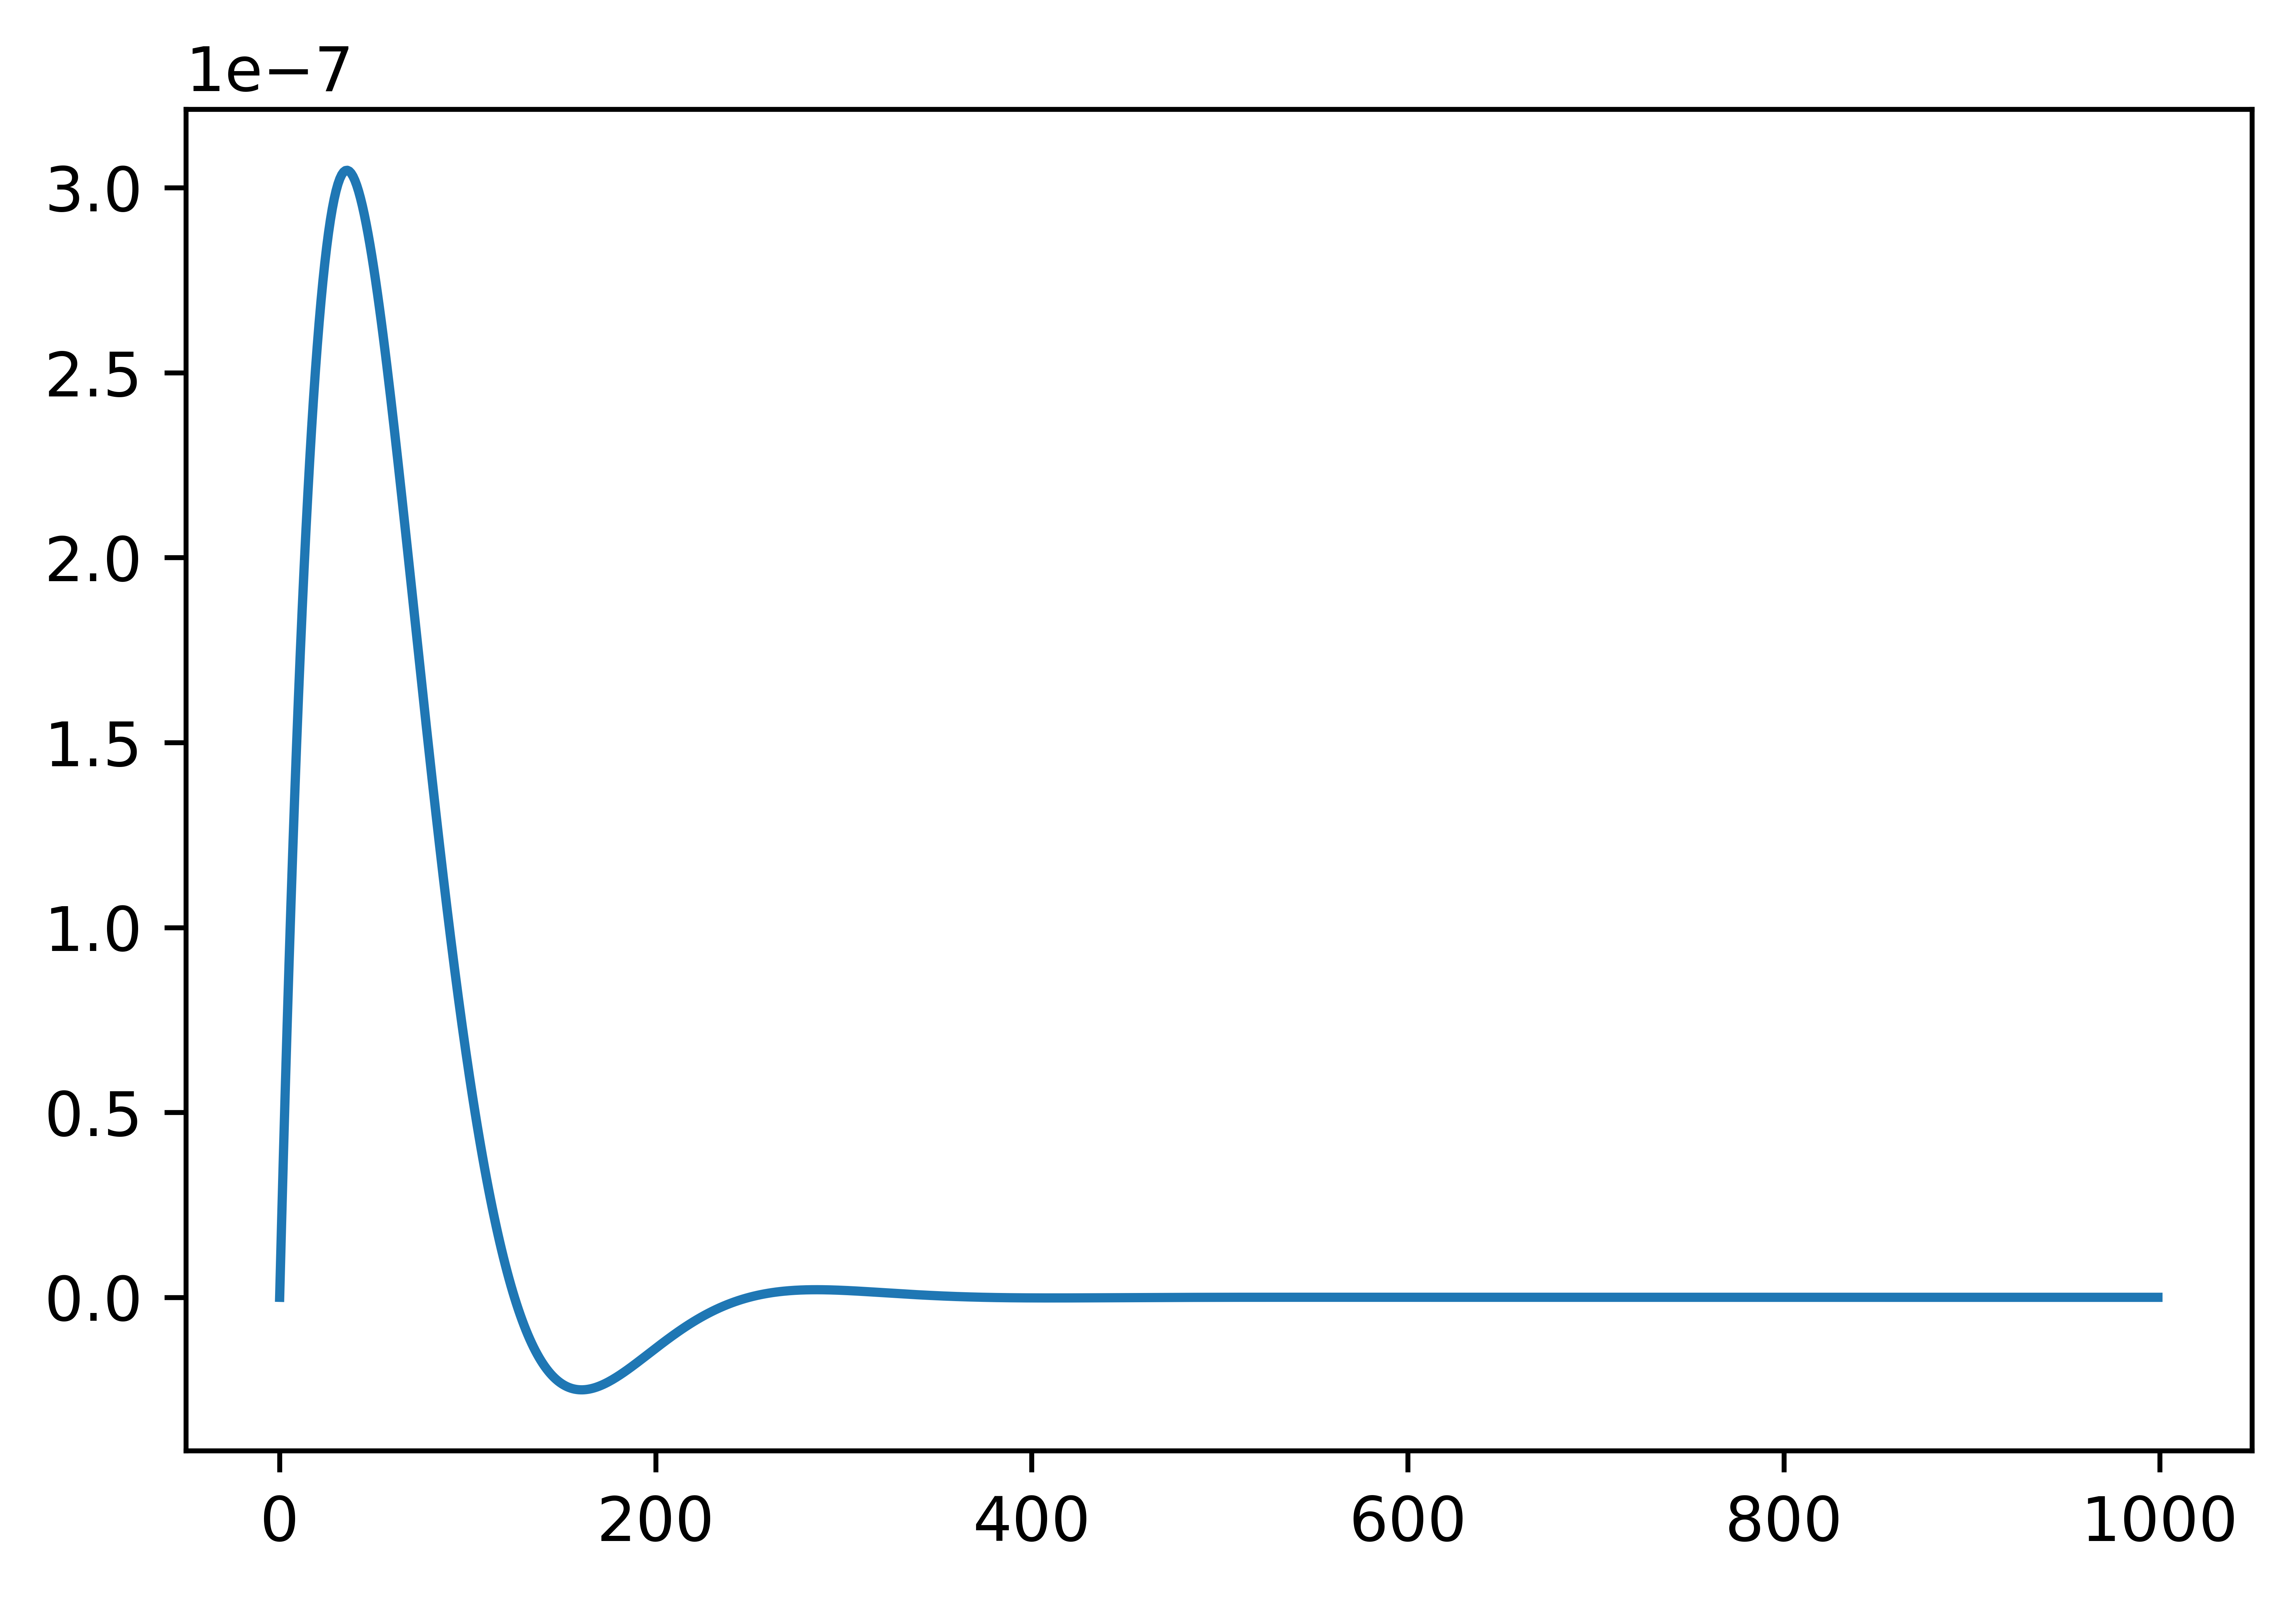

In [12]:
fig = plt.figure(dpi=1200)
plt.plot(sinInputSignal)
plt.show()

In [13]:
# MPI EJW Section #4 changes 

#initialize fields
vx=np.zeros((npx,gw1,gh1))
vy=np.zeros((npx,gw1,gh1))
vz=np.zeros((npx,gw1,gh1))

sxx=np.zeros((npx,gw1,gh1))
syy=np.zeros((npx,gw1,gh1))
szz=np.zeros((npx,gw1,gh1))
sxy=np.zeros((npx,gw1,gh1))
sxz=np.zeros((npx,gw1,gh1))
syz=np.zeros((npx,gw1,gh1))

#record the signal at a specified location
### ADD map function for this
signalLocx=int(gl1/2)
signalLocy=int(gw1/2)
signalLocz=int(gh1/2)

vxSignal=np.zeros(Tsteps)
vySignal=np.zeros(Tsteps)
vzSignal=np.zeros(Tsteps)

In [14]:

#record the signal at a specified location
### ADD map function for this
#SAME AS INPUTZ?

FSignalLocX=int(gl1/4)
BSignalLocX=int(3*gl1/4)
USignalLocX=int(gl1/4)
DSignalLocX=int(gl1/4)
RSignalLocX=int(gl1/4)
LSignalLocX=int(gl1/4)
MSignalLocX=int(gl1/4)

FSignalLocY=int(gw1/2)
BSignalLocY=int(gw1/2)
USignalLocY=int(gw1/2)
DSignalLocY=int(gw1/2)
RSignalLocY=int(gw1/4)
LSignalLocY=int(3*gw1/4)
MSignalLocY=int(gw1/2)

FSignalLocZ=int(gh1/2)
BSignalLocZ=int(gh1/2)
USignalLocZ=int(3*gh1/4)
DSignalLocZ=int(gh1/4)
RSignalLocZ=int(gh1/2)
LSignalLocZ=int(gh1/2)
MSignalLocZ=int(gh1/2)


#signal locations going to be a quarter of the way in the middle from the 
# Front, Back, Up side, Down side, Right, Left, and Middle Middle Middle
FSignal=np.zeros((Tsteps,3))
BSignal=np.zeros((Tsteps,3))
USignal=np.zeros((Tsteps,3))
DSignal=np.zeros((Tsteps,3))
RSignal=np.zeros((Tsteps,3))
LSignal=np.zeros((Tsteps,3))
MSignal=np.zeros((Tsteps,3))

In [15]:
# Grab splits and offsets for scattering arrays
# Only thing to scatter is matPropsglob
# v's and s's are zero to start + source applied later 
# in single proc's array
'''
if myid == 0:
    split=np.zeros(nprocs)
    split[:]=gw1*gh1*npx

    offset=np.zeros(nprocs)
    for i in range(nprocs):
        offset[i]=i*gw1*gh1*npx
else:
    split=None
    offset=None

split=mpi_comm.bcast(split)
offset=mpi_comm.bcast(offset)
'''

matProps0 = np.zeros((npx,gw1,gh1))
matProps1 = np.zeros((npx,gw1,gh1))
matProps2 = np.zeros((npx,gw1,gh1))
matProps3 = np.zeros((npx,gw1,gh1))
signalloc = np.zeros((npx,gw1,gh1))
'''
mpi_comm.Scatterv([matPropsglob[0,:,:,:],split,offset,MPI.DOUBLE], matProps0)
mpi_comm.Scatterv([matPropsglob[1,:,:,:],split,offset,MPI.DOUBLE], matProps1)
mpi_comm.Scatterv([matPropsglob[2,:,:,:],split,offset,MPI.DOUBLE], matProps2)
mpi_comm.Scatterv([matPropsglob[3,:,:,:],split,offset,MPI.DOUBLE], matProps3)
mpi_comm.Scatterv([signalLocation[:,:,:],split,offset,MPI.DOUBLE], signalloc)


matProps0=distBox(matProps0,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
matProps1=distBox(matProps1,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
matProps2=distBox(matProps2,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
matProps3=distBox(matProps3,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
signalloc=distBox(signalloc,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
'''
matProps0=matPropsglob[0,:,:,:]
matProps1=matPropsglob[1,:,:,:]
matProps2=matPropsglob[2,:,:,:]
matProps3=matPropsglob[3,:,:,:]
signalloc=signalLocation[:,:,:]


#Now slab has local versions with ghosts of matProps
if (myid == 0) :
    print('split matprops to globs, scratttered parameters to processors, line 449')



stime = time.time()

if (myid == 0 ):
    print('subs setup, line 1213.  About to start at ' + str(stime))
    

split matprops to globs, scratttered parameters to processors, line 449
subs setup, line 1213.  About to start at 1692202716.8675044


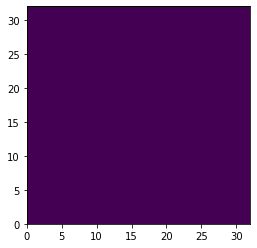

In [16]:
fig = plt.figure(figsize=(4,4))
plt.pcolormesh(matProps0[0,:,:].T)
plt.show()


In [17]:
np.set_printoptions(linewidth=128)


In [18]:
print(np.fliplr(matProps3[xmax-1,:,:]).T)


[[13. 99. 99. ... 99. 99. 14.]
 [ 3.  0.  0. ...  0.  0. 99.]
 [ 3.  0.  0. ...  0.  0. 99.]
 ...
 [ 3.  0.  0. ...  0.  0. 99.]
 [ 3.  0.  0. ...  0.  0. 99.]
 [ 9.  1.  1. ...  1.  1. 10.]]


In [19]:
#asdfadsf


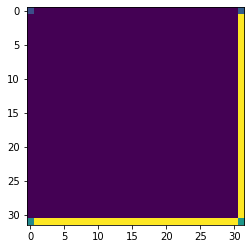

In [20]:
fig, ax = plt.subplots()

im = ax.imshow(matProps3[0,:,:])

def init():
    im.set_data(matProps3[0,:,:])
    return (im,)

# animation function. This is called sequentially
def animate(i):
    data_slice = matProps3[i,:,:].T
    im.set_data(data_slice)
    return (im,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True) 
anim.save('Rail.BCs.gif', writer='imagemagick', fps=30)


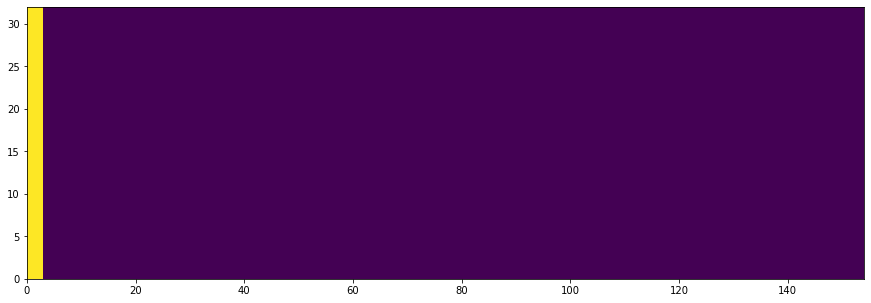

In [21]:
fig = plt.figure(figsize=(15,5))
#plt.pcolormesh(matPropsglob[3,:,1,:].T)
plt.pcolormesh(signalloc[:,gridStartHeadWidth+1,:].T)
plt.show()

In [22]:
print(np.fliplr(signalLocation[0:25,gridStartHeadWidth,:]).T)

[[1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [23]:
# asdfasdf
MidMatrix = np.zeros((gl1,Tsteps))

In [24]:
inner = []
outer=[]
for x in range(gl1):
    for y in range(gw1):
        for z in range(gh1):
            if matProps3[x,y,z] == 0:
                inner.append([x,y,z])
            else:
                outer.append([x,y,z])

In [25]:
for t in range(Tsteps):
     
    if FFunction == 2:
        vz += signalloc * sinInputSignal[t]
        print(np.sum(vz))
    
    if FFunction ==3:
        vx += signalloc * sinInputSignal[t]

    for pt in outer:
        updateStress(pt[0],pt[1],pt[2])
    
    for pt in inner:
        updateStress(pt[0],pt[1],pt[2])
    


    # cut boundaries off of arrays
    '''Remove for Jupyter single processor
    sxxt=sxx[1:npx+1,:,:]
    syyt=syy[1:npx+1,:,:]
    szzt=szz[1:npx+1,:,:]
    sxyt=sxy[1:npx+1,:,:]
    sxzt=sxz[1:npx+1,:,:]
    syzt=syz[1:npx+1,:,:]

    # redistrubute ghost/boundary values
    sxx=distBox(sxxt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    syy=distBox(syyt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    szz=distBox(szzt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    sxy=distBox(sxyt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    sxz=distBox(sxzt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    syz=distBox(syzt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    '''
    
    #if the forcing function is a stress
    if FFunction == 1:
        szz -= signalloc * specificWheelLoad

    for pt in outer:
        updateVelocity(pt[0],pt[1],pt[2])
    
    for pt in inner:
        updateVelocity(pt[0],pt[1],pt[2])

    MidMatrix[:,t] = vx[:,MSignalLocY,MSignalLocZ]
    '''Remove for Jupyter single processor
    # cut boundaries off of arrays
    vxt=vx[1:npx+1,:,:]
    vyt=vy[1:npx+1,:,:]
    vzt=vz[1:npx+1,:,:]

    # redistrubute ghost/boundary values
    vx=distBox(vxt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    vy=distBox(vyt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        
    vz=distBox(vzt,myid,gl1,gw1,gh1,npx,nprocs,mpi_comm)        

    #record signals
    if (myid==signalLocxid) :
        vxSignal[t]=vx[signalLocxlocx,signalLocy,signalLocz]
        vySignal[t]=vy[signalLocxlocx,signalLocy,signalLocz]
        vzSignal[t]=vz[signalLocxlocx,signalLocy,signalLocz]
    '''
    vxg=vx #[1:npx+1,:,:]        
    #mpi_comm.Gatherv(vxt,[vxg,split,offset,MPI.DOUBLE])
    vyg=vy#[1:npx+1,:,:]        
    #mpi_comm.Gatherv(vyt,[vyg,split,offset,MPI.DOUBLE])
    vzg=vz#[1:npx+1,:,:]        
    #mpi_comm.Gatherv(vzt,[vzg,split,offset,MPI.DOUBLE])

    
    if (myid == 0 ) :
        USignal[t]=[vxg[USignalLocX,USignalLocY,USignalLocZ],vyg[USignalLocX,USignalLocY,USignalLocZ],vzg[USignalLocX,USignalLocY,USignalLocZ]]
        DSignal[t]=[vxg[DSignalLocX,DSignalLocY,DSignalLocZ],vyg[DSignalLocX,DSignalLocY,DSignalLocZ],vzg[DSignalLocX,DSignalLocY,DSignalLocZ]]
        RSignal[t]=[vxg[RSignalLocX,RSignalLocY,RSignalLocZ],vyg[RSignalLocX,RSignalLocY,RSignalLocZ],vzg[RSignalLocX,RSignalLocY,RSignalLocZ]]
        LSignal[t]=[vxg[LSignalLocX,LSignalLocY,LSignalLocZ],vyg[LSignalLocX,LSignalLocY,LSignalLocZ],vzg[LSignalLocX,LSignalLocY,LSignalLocZ]]
        MSignal[t]=[vxg[MSignalLocX,MSignalLocY,MSignalLocZ],vyg[MSignalLocX,MSignalLocY,MSignalLocZ],vzg[MSignalLocX,MSignalLocY,MSignalLocZ]]
        FSignal[t]=[vxg[FSignalLocX,FSignalLocY,FSignalLocZ],vyg[FSignalLocX,FSignalLocY,FSignalLocZ],vzg[FSignalLocX,FSignalLocY,FSignalLocZ]]
        BSignal[t]=[vxg[BSignalLocX,BSignalLocY,BSignalLocZ],vyg[BSignalLocX,BSignalLocY,BSignalLocZ],vzg[BSignalLocX,BSignalLocY,BSignalLocZ]]

        if t%10==0:
        
            fig=plt.figure()
            plt.contourf(np.transpose(vxg[:,:,int(gh1/2)]), cmap='seismic')
            plt.savefig(imFolder+'Mid/vyMidHeightShear'+str(t).zfill(5)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)
            
            fig=plt.figure()
            plt.contourf(np.transpose(vxg[:,int(gw1/2),:]), cmap='seismic')
            plt.savefig(imFolder + 'Vert/vyVertShear'+str(t).zfill(5)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)    
            
            fig=plt.figure()
            plt.contourf(np.transpose(vxg[int(gl1/2),:,:]), cmap='seismic')
            plt.savefig(imFolder + 'Head/vyMidLenShear'+str(t).zfill(5)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)  
    
            fig=plt.figure()
            plt.contourf(np.transpose(vxg[:,:,int(gh1/4)]), cmap='seismic')
            plt.savefig(imFolder+'zplane25/vy25Shear'+str(t).zfill(5)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)
            
            fig=plt.figure()
            plt.contourf(np.transpose(vxg[:,:,int(3*gh1/4)]), cmap='seismic')
            plt.savefig(imFolder+'zplane75/vy75Shear'+str(t).zfill(5)+'.png')
            # SideRub vs TopHit for which case
            plt.close(fig)
            

    # Collect vx, sxx checksum contributions for printing
    vxt=vx[1:npx+1,:,:]
    sxxt=sxx[1:npx+1,:,:]

    #ckvs=np.array(0.0,'d')
    #ckss=np.array(0.0,'d')
    
    ckv=np.sum(np.absolute(vxg))
    cks=np.sum(np.absolute(sxx))
    #mpi_comm.Reduce(ckv,ckvs,op=MPI.SUM,root=0)
    #mpi_comm.Reduce(cks,ckss,op=MPI.SUM,root=0)

    if (myid == 0 ):
        print(t,'/',Tsteps-1,'checksums vx, sxx:',ckv,cks, (time.time()-stime)/60.0)
    sys.stdout.flush()

0 / 999 checksums vx, sxx: 0.0 0.0 0.25506117741266887
1 / 999 checksums vx, sxx: 5.7952583153241086e-05 469.31931773662427 0.32484309673309325
2 / 999 checksums vx, sxx: 0.0001713148324366122 1853.9832817890187 0.394817586739858
3 / 999 checksums vx, sxx: 0.0003368468286366374 4575.055356662814 0.46443920532862343
4 / 999 checksums vx, sxx: 0.0005496964754812037 9006.617828632736 0.5427516818046569
5 / 999 checksums vx, sxx: 0.0008032630991624066 15403.488875505764 0.6262341260910034
6 / 999 checksums vx, sxx: 0.001090759294645314 23812.588637459703 0.6960671424865723
7 / 999 checksums vx, sxx: 0.0014076315014967642 34058.68920977605 0.7656121691068013
8 / 999 checksums vx, sxx: 0.0017526370682869872 45857.02323302219 0.8354044198989868
9 / 999 checksums vx, sxx: 0.0021262818391958754 58986.917656539576 0.9050180435180664
10 / 999 checksums vx, sxx: 0.0025278950113078224 73386.34099923607 0.9815279165903728
11 / 999 checksums vx, sxx: 0.0029541370888619394 89090.67776390424 1.05147354

96 / 999 checksums vx, sxx: 0.027013762665514314 1255021.8887201308 7.072353903452555
97 / 999 checksums vx, sxx: 0.02717334512123316 1257604.5912661534 7.142556301752726
98 / 999 checksums vx, sxx: 0.027340123456869213 1260236.3342557086 7.212758779525757
99 / 999 checksums vx, sxx: 0.02751789937079764 1262847.7731379736 7.282735228538513
100 / 999 checksums vx, sxx: 0.027712113205318783 1265683.2582907516 7.359597365061442
101 / 999 checksums vx, sxx: 0.027910760645489897 1268483.5429428036 7.429002149899801
102 / 999 checksums vx, sxx: 0.028124922515113785 1271423.7493523902 7.498477975527446
103 / 999 checksums vx, sxx: 0.028352527472642042 1274406.5668372058 7.567985292275747
104 / 999 checksums vx, sxx: 0.02858767415635968 1277643.8769787564 7.637560228506724
105 / 999 checksums vx, sxx: 0.028839924168439172 1280956.7784780997 7.706936287879944
106 / 999 checksums vx, sxx: 0.029107203897652013 1284464.2582548794 7.77637886206309
107 / 999 checksums vx, sxx: 0.029384258982235265 1

192 / 999 checksums vx, sxx: 0.15602488225392308 5414052.187149883 13.873390471935272
193 / 999 checksums vx, sxx: 0.16033391863034538 5577679.248160351 13.943026582400003
194 / 999 checksums vx, sxx: 0.16483351264229784 5745886.173201792 14.014127600193024
195 / 999 checksums vx, sxx: 0.16922496496375508 5912339.067975134 14.085464072227477
196 / 999 checksums vx, sxx: 0.17399731624979575 6099951.748043628 14.157298151652018
197 / 999 checksums vx, sxx: 0.1788981330673767 6284731.463569319 14.226848447322846
198 / 999 checksums vx, sxx: 0.1839002483539185 6482383.998771348 14.296254575252533
199 / 999 checksums vx, sxx: 0.18898115328333692 6683798.999193159 14.36821499268214
200 / 999 checksums vx, sxx: 0.19443941557508063 6898825.546532701 14.44464084704717
201 / 999 checksums vx, sxx: 0.20018356926720587 7115114.471289921 14.515087099870046
202 / 999 checksums vx, sxx: 0.20583692862489003 7341086.399811556 14.585508000850677
203 / 999 checksums vx, sxx: 0.21192564639918493 7581366.8

289 / 999 checksums vx, sxx: 5.151100413638851 182872881.4093445 20.76701463460922
290 / 999 checksums vx, sxx: 5.272926904288278 193676476.59583253 20.843541161219278
291 / 999 checksums vx, sxx: 5.4138022327651285 205510298.21253496 20.91314244667689
292 / 999 checksums vx, sxx: 5.495491846364305 218943938.0422252 20.984333407878875
293 / 999 checksums vx, sxx: 5.58605532572287 231464842.2198002 21.05384890238444
294 / 999 checksums vx, sxx: 5.788609692827783 244858062.75875953 21.124512565135955
295 / 999 checksums vx, sxx: 6.0903576967891375 255003638.74624005 21.19483966032664
296 / 999 checksums vx, sxx: 6.457239087377749 265326229.9067768 21.264751438299815
297 / 999 checksums vx, sxx: 6.929414457832179 269932009.87689114 21.334259740511577
298 / 999 checksums vx, sxx: 7.437487783552353 273874685.9720633 21.40372143983841
299 / 999 checksums vx, sxx: 8.014505171730352 272858491.62900674 21.473588474591573
300 / 999 checksums vx, sxx: 8.437448990285722 273684683.4824368 21.550570

387 / 999 checksums vx, sxx: 456.0634681546856 16528675153.978071 27.726953109105427
388 / 999 checksums vx, sxx: 472.5009068007495 17673888879.220264 27.797034867604573
389 / 999 checksums vx, sxx: 489.98367678451746 18787112213.63202 27.866726855436962
390 / 999 checksums vx, sxx: 517.7365208208937 19826348038.05768 27.943742756048838
391 / 999 checksums vx, sxx: 540.2676749344781 20508757445.419453 28.013701844215394
392 / 999 checksums vx, sxx: 566.8034817999771 21359667798.75633 28.08315315643946
393 / 999 checksums vx, sxx: 582.0802727994193 22466148314.375134 28.156076983610788
394 / 999 checksums vx, sxx: 607.3442354115682 23980059338.303246 28.227974390983583
395 / 999 checksums vx, sxx: 628.6810021961716 25187626540.693497 28.297817707061768
396 / 999 checksums vx, sxx: 670.4842176521585 26275830454.531734 28.367611547311146
397 / 999 checksums vx, sxx: 706.9267391587694 27211283473.021458 28.43765392700831
398 / 999 checksums vx, sxx: 752.7965885281527 28318951066.895374 28.

485 / 999 checksums vx, sxx: 47690.2261854112 1854788116056.5896 34.678962580362956
486 / 999 checksums vx, sxx: 49630.01540685618 1943246090421.4033 34.74848914941152
487 / 999 checksums vx, sxx: 52994.49534160622 2060256330777.8916 34.81812556187312
488 / 999 checksums vx, sxx: 55271.10049791888 2149470886975.5361 34.887640682856244
489 / 999 checksums vx, sxx: 58394.15095548928 2272652995256.546 34.95759962399801
490 / 999 checksums vx, sxx: 60432.515692641806 2375699229095.1357 35.03438903888067
491 / 999 checksums vx, sxx: 63539.21656832926 2528945554751.7563 35.10730378627777
492 / 999 checksums vx, sxx: 66555.5488819216 2631905003348.9316 35.18146230777105
493 / 999 checksums vx, sxx: 70699.46825752685 2788800212863.29 35.25291684865952
494 / 999 checksums vx, sxx: 74374.53033029243 2892235389173.153 35.32294683059057
495 / 999 checksums vx, sxx: 78181.13608928329 3056544755072.905 35.39475876887639
496 / 999 checksums vx, sxx: 81469.08922154982 3195887051261.0835 35.46429810126

583 / 999 checksums vx, sxx: 6238143.377065364 247931208964859.2 41.65445375442505
584 / 999 checksums vx, sxx: 6543759.4947485365 259845126095985.2 41.724297471841176
585 / 999 checksums vx, sxx: 6993734.801735536 274093691399714.5 41.79484295447667
586 / 999 checksums vx, sxx: 7370244.506362194 286528592538961.8 41.87097302277883
587 / 999 checksums vx, sxx: 7778687.200669243 300246119966079.75 41.940909469127654
588 / 999 checksums vx, sxx: 8094366.813110797 315833359446177.6 42.010378789901736
589 / 999 checksums vx, sxx: 8501345.248910567 332392573092971.9 42.07986662785212
590 / 999 checksums vx, sxx: 8893511.678578973 351083717715290.25 42.15735935767491
591 / 999 checksums vx, sxx: 9445025.920598801 367561778429037.3 42.22739154497783
592 / 999 checksums vx, sxx: 9961110.576050403 387674237419363.56 42.296904329458876
593 / 999 checksums vx, sxx: 10446994.061640404 405431386426255.25 42.36681731144587
594 / 999 checksums vx, sxx: 10890971.221794158 429213034987086.5 42.43641047

680 / 999 checksums vx, sxx: 641531122.4414319 2.3383603944526756e+16 48.55663534005483
681 / 999 checksums vx, sxx: 604699286.0904535 2.8111745489541896e+16 48.62643228371938
682 / 999 checksums vx, sxx: 661707796.890086 3.0827585528053876e+16 48.69619157711665
683 / 999 checksums vx, sxx: 763965673.4375323 3.0479334160929252e+16 48.76554186344147
684 / 999 checksums vx, sxx: 845357455.2252198 2.807678493517007e+16 48.834897915522255
685 / 999 checksums vx, sxx: 862868464.2866347 2.708683848308239e+16 48.9048664410909
686 / 999 checksums vx, sxx: 824356271.7074223 3.244818166016028e+16 48.974362421035764
687 / 999 checksums vx, sxx: 794764638.0087808 3.821496960354847e+16 49.04425050417582
688 / 999 checksums vx, sxx: 912806867.4505715 4.070181083515534e+16 49.11572738091151
689 / 999 checksums vx, sxx: 1050504329.6223679 3.939497792349027e+16 49.190454892317454
690 / 999 checksums vx, sxx: 1135585049.3118186 3.556836943570239e+16 49.270000859101614
691 / 999 checksums vx, sxx: 112737

774 / 999 checksums vx, sxx: 83371192012.57826 3.200902448710897e+18 55.2523065606753
775 / 999 checksums vx, sxx: 85858348396.5637 3.3700109778183895e+18 55.3217230796814
776 / 999 checksums vx, sxx: 89641584675.95331 3.565053367907602e+18 55.39120032389959
777 / 999 checksums vx, sxx: 93482719965.57288 3.8520244725329664e+18 55.46098791360855
778 / 999 checksums vx, sxx: 99891806994.39711 4.031517202251236e+18 55.53398108084996
779 / 999 checksums vx, sxx: 108266549728.40224 4.2018641103365914e+18 55.603485767046614
780 / 999 checksums vx, sxx: 114772315223.24603 4.2572726856219054e+18 55.67957148949305
781 / 999 checksums vx, sxx: 118928604793.76495 4.466579429919535e+18 55.74954439798991
782 / 999 checksums vx, sxx: 119851622335.73416 4.835936166492283e+18 55.819062260786694
783 / 999 checksums vx, sxx: 125093537754.38573 5.321232064135205e+18 55.88900566895803
784 / 999 checksums vx, sxx: 135582732645.01724 5.5577471925704e+18 55.95902272462845
785 / 999 checksums vx, sxx: 1493128

868 / 999 checksums vx, sxx: 9780831464209.023 3.707621712722166e+20 61.89750421047211
869 / 999 checksums vx, sxx: 10098713569129.605 4.037638301509192e+20 61.96882784366608
870 / 999 checksums vx, sxx: 10521483129477.908 4.316784510842229e+20 62.045949260393776
871 / 999 checksums vx, sxx: 11327710098741.914 4.578829751614034e+20 62.11535827716192
872 / 999 checksums vx, sxx: 12003489636970.338 4.6328264461479936e+20 62.18519633611043
873 / 999 checksums vx, sxx: 12802848222527.77 4.843817883917535e+20 62.25458445946376
874 / 999 checksums vx, sxx: 13133663135989.244 5.1009613778380993e+20 62.32401506900787
875 / 999 checksums vx, sxx: 13838649037036.479 5.485160839567444e+20 62.39345207214355
876 / 999 checksums vx, sxx: 14509289930701.03 5.8046559093385187e+20 62.46287718613942
877 / 999 checksums vx, sxx: 15404207338702.973 6.122965872457013e+20 62.532216640313464
878 / 999 checksums vx, sxx: 16121865283856.762 6.333967231622924e+20 62.601708908875786
879 / 999 checksums vx, sxx: 

962 / 999 checksums vx, sxx: 1164717774368192.8 4.613547149058448e+22 68.56307513713837
963 / 999 checksums vx, sxx: 1232560420649502.5 4.763941804591628e+22 68.63267225027084
964 / 999 checksums vx, sxx: 1293505897254775.0 5.057352677311994e+22 68.70231262048085
965 / 999 checksums vx, sxx: 1356146464373959.2 5.28189306050393e+22 68.77193168004354
966 / 999 checksums vx, sxx: 1438054859229069.8 5.555649157201803e+22 68.84160071611404
967 / 999 checksums vx, sxx: 1512137417241159.8 5.8440551708277044e+22 68.91120787064234
968 / 999 checksums vx, sxx: 1581632001268226.8 6.166262758166557e+22 68.98088002999624
969 / 999 checksums vx, sxx: 1635581821130426.5 6.437173683257091e+22 69.05056865215302
970 / 999 checksums vx, sxx: 1716806006123857.2 6.9217467896817005e+22 69.12699771324793
971 / 999 checksums vx, sxx: 1828242115349447.2 7.224357229212438e+22 69.19715062379836
972 / 999 checksums vx, sxx: 1972514420555946.5 7.4758673908501016e+22 69.26663624842962
973 / 999 checksums vx, sxx: 2

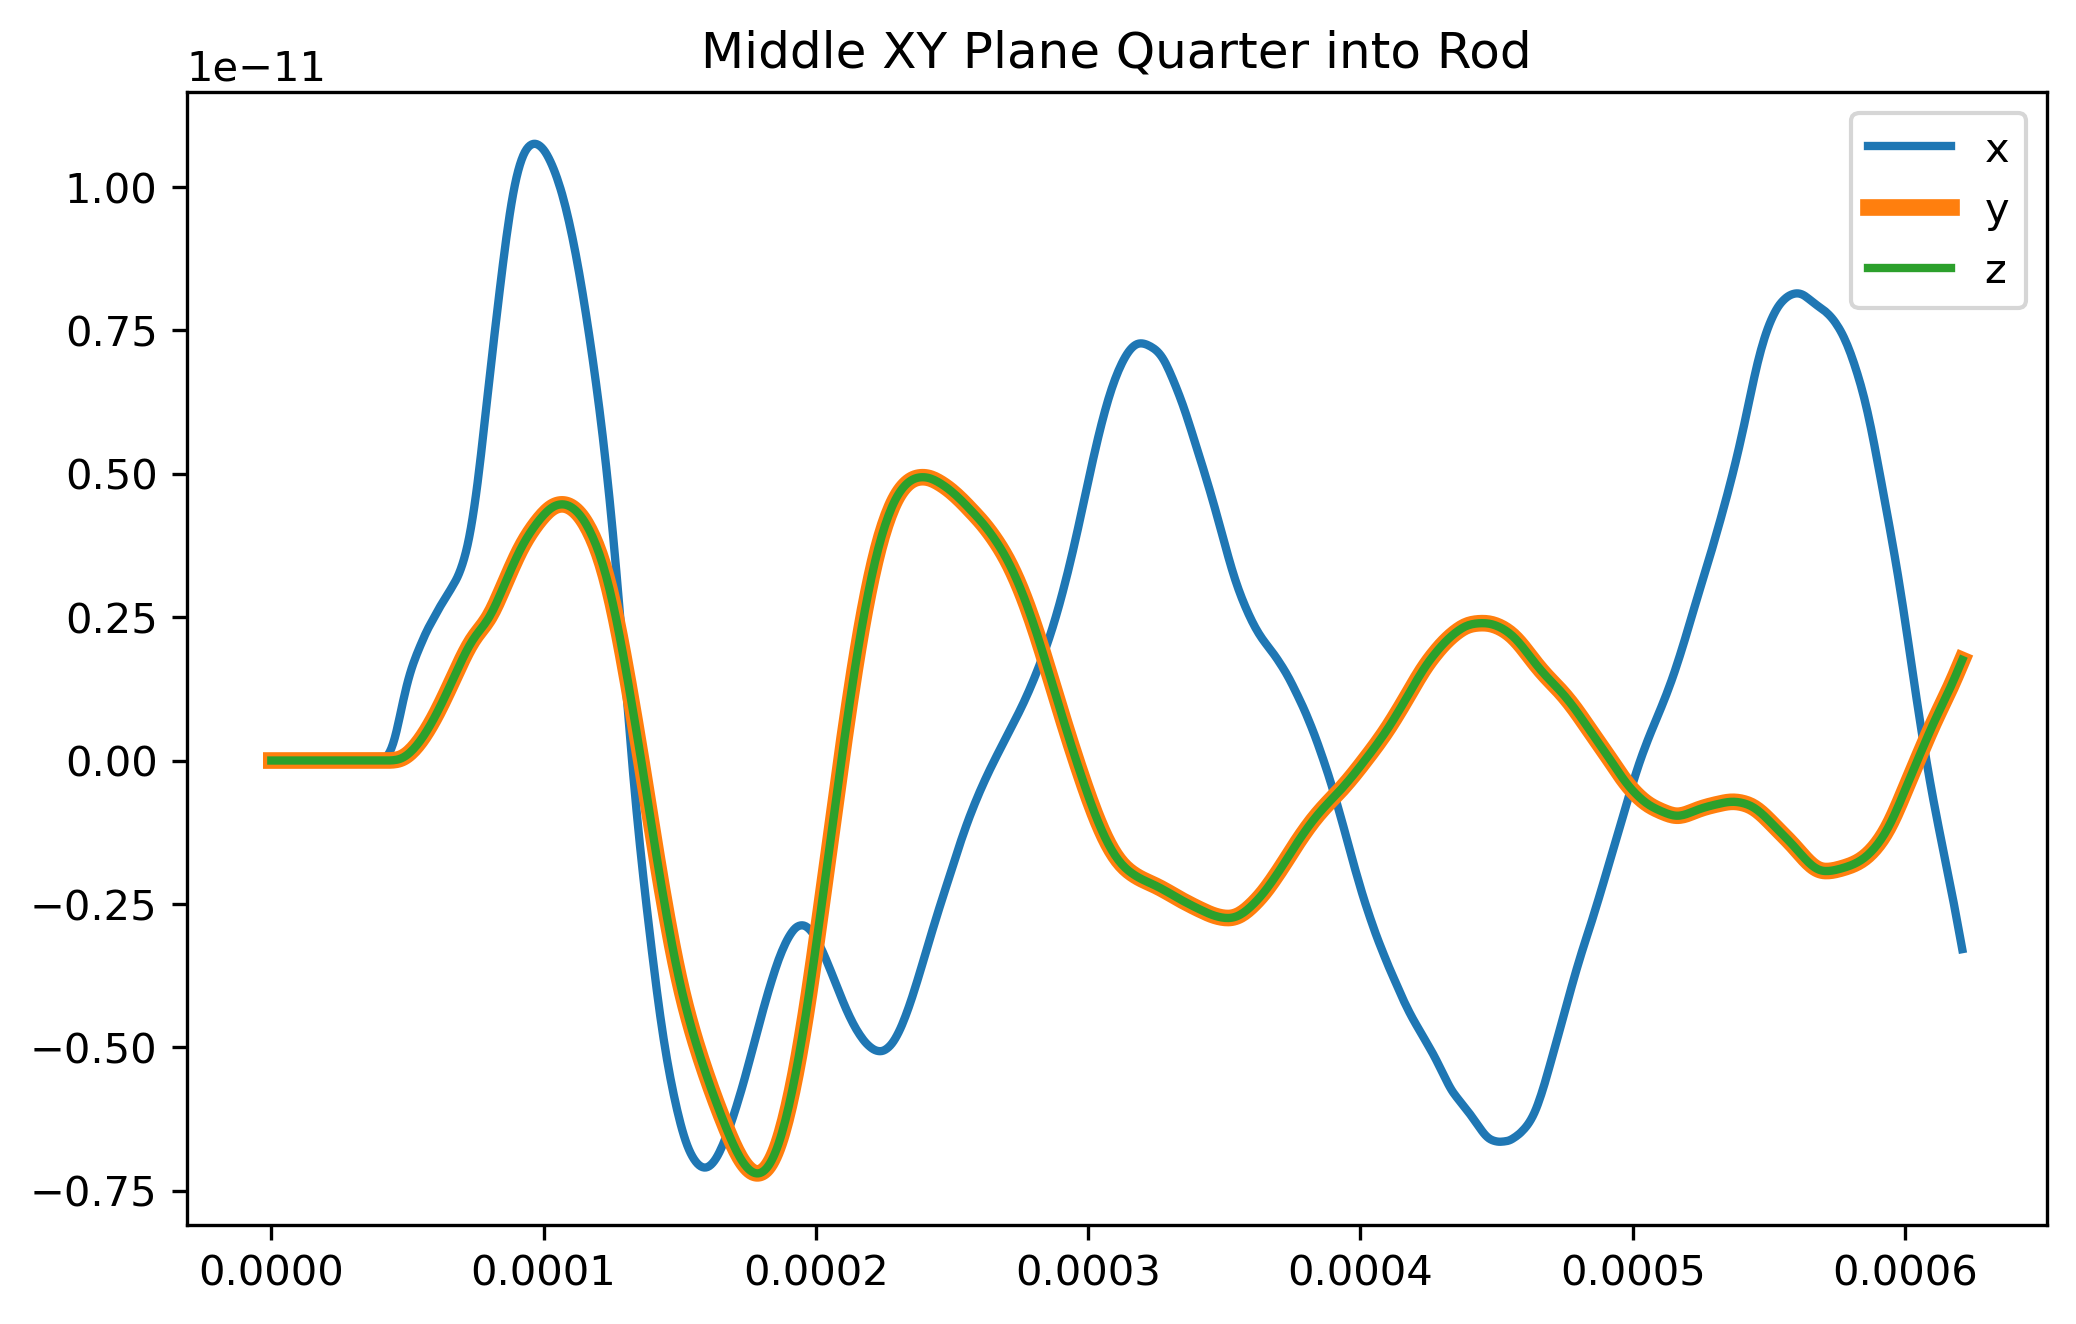

(1000, 3) (1000, 3)


"\nif (myid == signalLocxid) :\n    plt.clf()\n    plt.plot(vxSignal)\n    plt.savefig('vxsignal.png')\n\nif (myid == signalLocxid) :\n    plt.clf()\n    plt.plot(vySignal)\n    plt.savefig('vysignal.png')\n\nif (myid == signalLocxid) :\n    plt.clf()\n    plt.plot(vzSignal)\n    plt.savefig('vzsignal.png')\n"

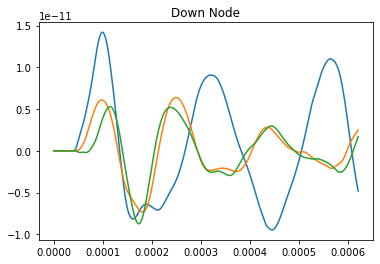

In [26]:
if (myid == 0) :
    fig=plt.figure(figsize=(8,5), dpi=figDPI)
    plt.plot(MSignal[:,0])
    plt.savefig(imFolder+'vxsignalCA.png')
    plt.clf()
    plt.plot(MSignal[:,1])
    plt.savefig(imFolder+'vysignalCA.png')
    plt.clf()
    plt.plot(MSignal[:,2])
    plt.savefig(imFolder+'vzsignalCA.png')

    vxDisplacement = [0]
    vyDisplacement = [0]
    vzDisplacement = [0]
    
    Times = np.linspace(0, len(MSignal), num=len(MSignal)+1)
    Times *= ts
    
    for i in range(len(MSignal)):
        vxDisplacement.append(vxDisplacement[i-1]+MSignal[i][0] * ts)
        vyDisplacement.append(vyDisplacement[i-1]+MSignal[i][1] * ts)
        vzDisplacement.append(vzDisplacement[i-1]+MSignal[i][2] * ts)
    
    plt.clf()
    plt.title('Middle Node')
    plt.plot(Times,vxDisplacement,label='x')
    plt.plot(Times,vyDisplacement,label='y')
    plt.plot(Times,vzDisplacement,label='z')
    plt.legend()
    plt.savefig(imFolder+runName+'DisplaceMid.png')
    #plt.show()
    
    vxDisplacement = [0]
    vyDisplacement = [0]
    vzDisplacement = [0]
    
    for i in range(len(FSignal)):
        vxDisplacement.append(vxDisplacement[i-1]+FSignal[i][0] * ts)
        vyDisplacement.append(vyDisplacement[i-1]+FSignal[i][1] * ts)
        vzDisplacement.append(vzDisplacement[i-1]+FSignal[i][2] * ts)

    plt.clf()
    plt.title('Middle XY Plane Quarter into Rod')
    plt.plot(Times,vxDisplacement,label='x', linewidth=2)
    plt.plot(Times,vyDisplacement,label='y', linewidth=4)
    plt.plot(Times,vzDisplacement,label='z', linewidth=2)
    plt.legend()
    plt.savefig(imFolder+runName+'DisplaceFront.png')
    plt.show()
    
    vxDisplacement = [0]
    vyDisplacement = [0]
    vzDisplacement = [0]
    
    for i in range(len(BSignal)):
        vxDisplacement.append(vxDisplacement[i-1]+BSignal[i][0] * ts)
        vyDisplacement.append(vyDisplacement[i-1]+BSignal[i][1] * ts)
        vzDisplacement.append(vzDisplacement[i-1]+BSignal[i][2] * ts)

    plt.clf()
    plt.title('Back Node')
    plt.plot(Times,vxDisplacement)
    plt.plot(Times,vyDisplacement)
    plt.plot(Times,vzDisplacement)
    plt.savefig(imFolder+runName+'DisplaceBack.png')
     
    vxDisplacement = [0]
    vyDisplacement = [0]
    vzDisplacement = [0]
    
    for i in range(len(RSignal)):
        vxDisplacement.append(vxDisplacement[i-1]+RSignal[i][0] * ts)
        vyDisplacement.append(vyDisplacement[i-1]+RSignal[i][1] * ts)
        vzDisplacement.append(vzDisplacement[i-1]+RSignal[i][2] * ts)

    plt.clf()
    plt.title('Right Node')
    plt.plot(Times,vxDisplacement)
    plt.plot(Times,vyDisplacement)
    plt.plot(Times,vzDisplacement)
    plt.savefig(imFolder+runName+'DisplaceRight.png')
     
    vxDisplacement = [0]
    vyDisplacement = [0]
    vzDisplacement = [0]
    
    for i in range(len(LSignal)):
        vxDisplacement.append(vxDisplacement[i-1]+LSignal[i][0] * ts)
        vyDisplacement.append(vyDisplacement[i-1]+LSignal[i][1] * ts)
        vzDisplacement.append(vzDisplacement[i-1]+LSignal[i][2] * ts)

    plt.clf()
    plt.title('Left Node')
    plt.plot(Times,vxDisplacement)
    plt.plot(Times,vyDisplacement)
    plt.plot(Times,vzDisplacement)
    plt.savefig(imFolder+runName+'DisplaceLeft.png')
     
    vxDisplacement = [0]
    vyDisplacement = [0]
    vzDisplacement = [0]
    
    for i in range(len(USignal)):
        vxDisplacement.append(vxDisplacement[i-1]+USignal[i][0] * ts)
        vyDisplacement.append(vyDisplacement[i-1]+USignal[i][1] * ts)
        vzDisplacement.append(vzDisplacement[i-1]+USignal[i][2] * ts)

    plt.clf()
    plt.title('Up Node')
    plt.plot(Times,vxDisplacement)
    plt.plot(Times,vyDisplacement)
    plt.plot(Times,vzDisplacement)
    plt.savefig(imFolder+runName+'DisplaceUp.png')
     
        
    vxDisplacement = [0]
    vyDisplacement = [0]
    vzDisplacement = [0]
    
    for i in range(len(DSignal)):
        vxDisplacement.append(vxDisplacement[i-1]+DSignal[i][0] * ts)
        vyDisplacement.append(vyDisplacement[i-1]+DSignal[i][1] * ts)
        vzDisplacement.append(vzDisplacement[i-1]+DSignal[i][2] * ts)

    plt.clf()
    plt.title('Down Node')
    plt.plot(Times,vxDisplacement)
    plt.plot(Times,vyDisplacement)
    plt.plot(Times,vzDisplacement)
    plt.savefig(imFolder+runName+'DisplaceDown.png')
     
   

    #Data = [MSignal,USignal,DSignal,LSignal,RSignal,FSignal,BSignal]
    print(np.shape(MSignal), np.shape(np.asarray(MSignal)))


#    if (myid == 0 ):
#        print(t,'/',Tsteps-1,'checksums vx, sxx:',ckvs,ckss, time.time()-stime)
#    sys.stdout.flush()

'''
if (myid == signalLocxid) :
    plt.clf()
    plt.plot(vxSignal)
    plt.savefig('vxsignal.png')

if (myid == signalLocxid) :
    plt.clf()
    plt.plot(vySignal)
    plt.savefig('vysignal.png')

if (myid == signalLocxid) :
    plt.clf()
    plt.plot(vzSignal)
    plt.savefig('vzsignal.png')
'''

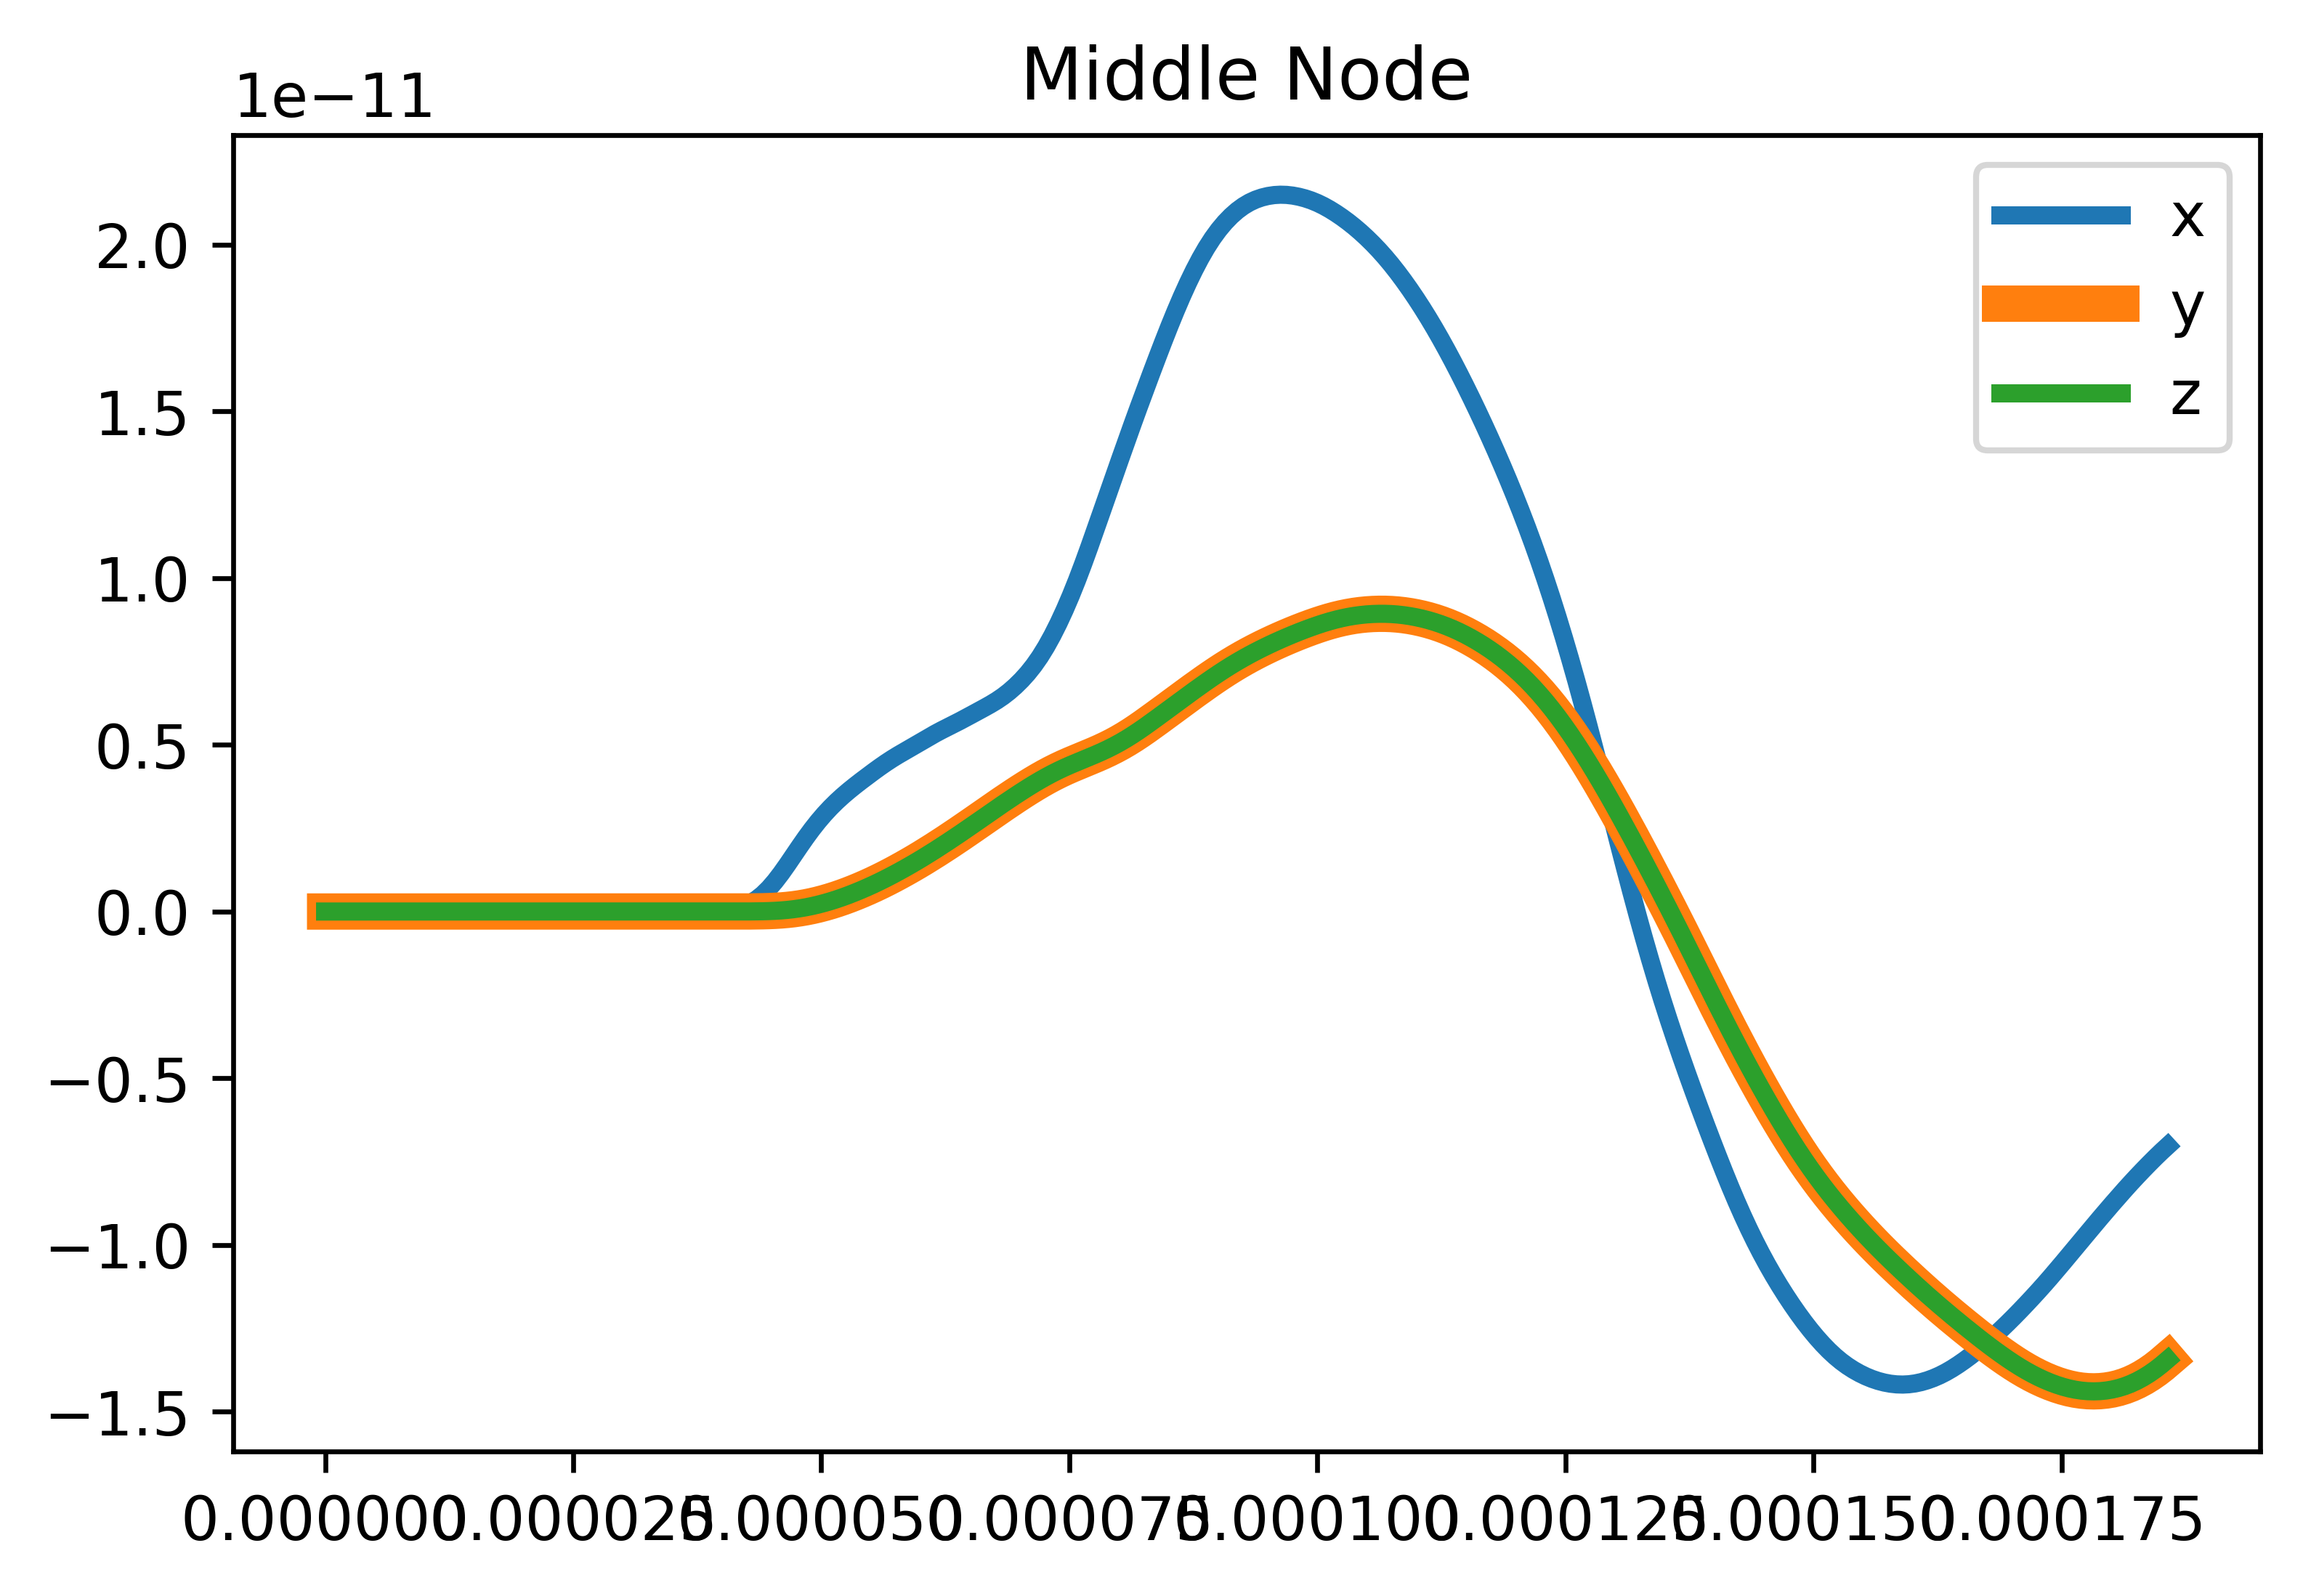

In [27]:
Displacement = np.zeros(np.shape(MSignal))

for i in range(np.shape(MSignal)[1]):
    for j in range(np.shape(MSignal)[0]):
        if j == 0:
            Displacement[j,i]=MSignal[j,i]*ts
        else:
            Displacement[j,i]=Displacement[j-1,i]+MSignal[j,i]*ts
    
fig = plt.figure(dpi=600)
endnode=300
plt.clf()
plt.title('Middle Node')
plt.plot(Times[:endnode],Displacement[:endnode,0],label='x', linewidth = 3)
plt.plot(Times[:endnode],Displacement[:endnode,1],label='y', linewidth = 6)
plt.plot(Times[:endnode],Displacement[:endnode,2],label='z', linewidth = 3)
plt.legend()
plt.savefig(imFolder+runName+'DisplaceMid2.png')
plt.show()

In [28]:
MidDisplace = np.zeros(np.shape(MidMatrix))

In [29]:
for i in range(np.shape(MidMatrix)[0]):
    for j in range(np.shape(MidMatrix)[1]):
        if j == 0:
            MidDisplace[i,j]=MidMatrix[i,j]*ts
        else:
            MidDisplace[i,j]=MidDisplace[i,j-1]+MidMatrix[i,j]*ts

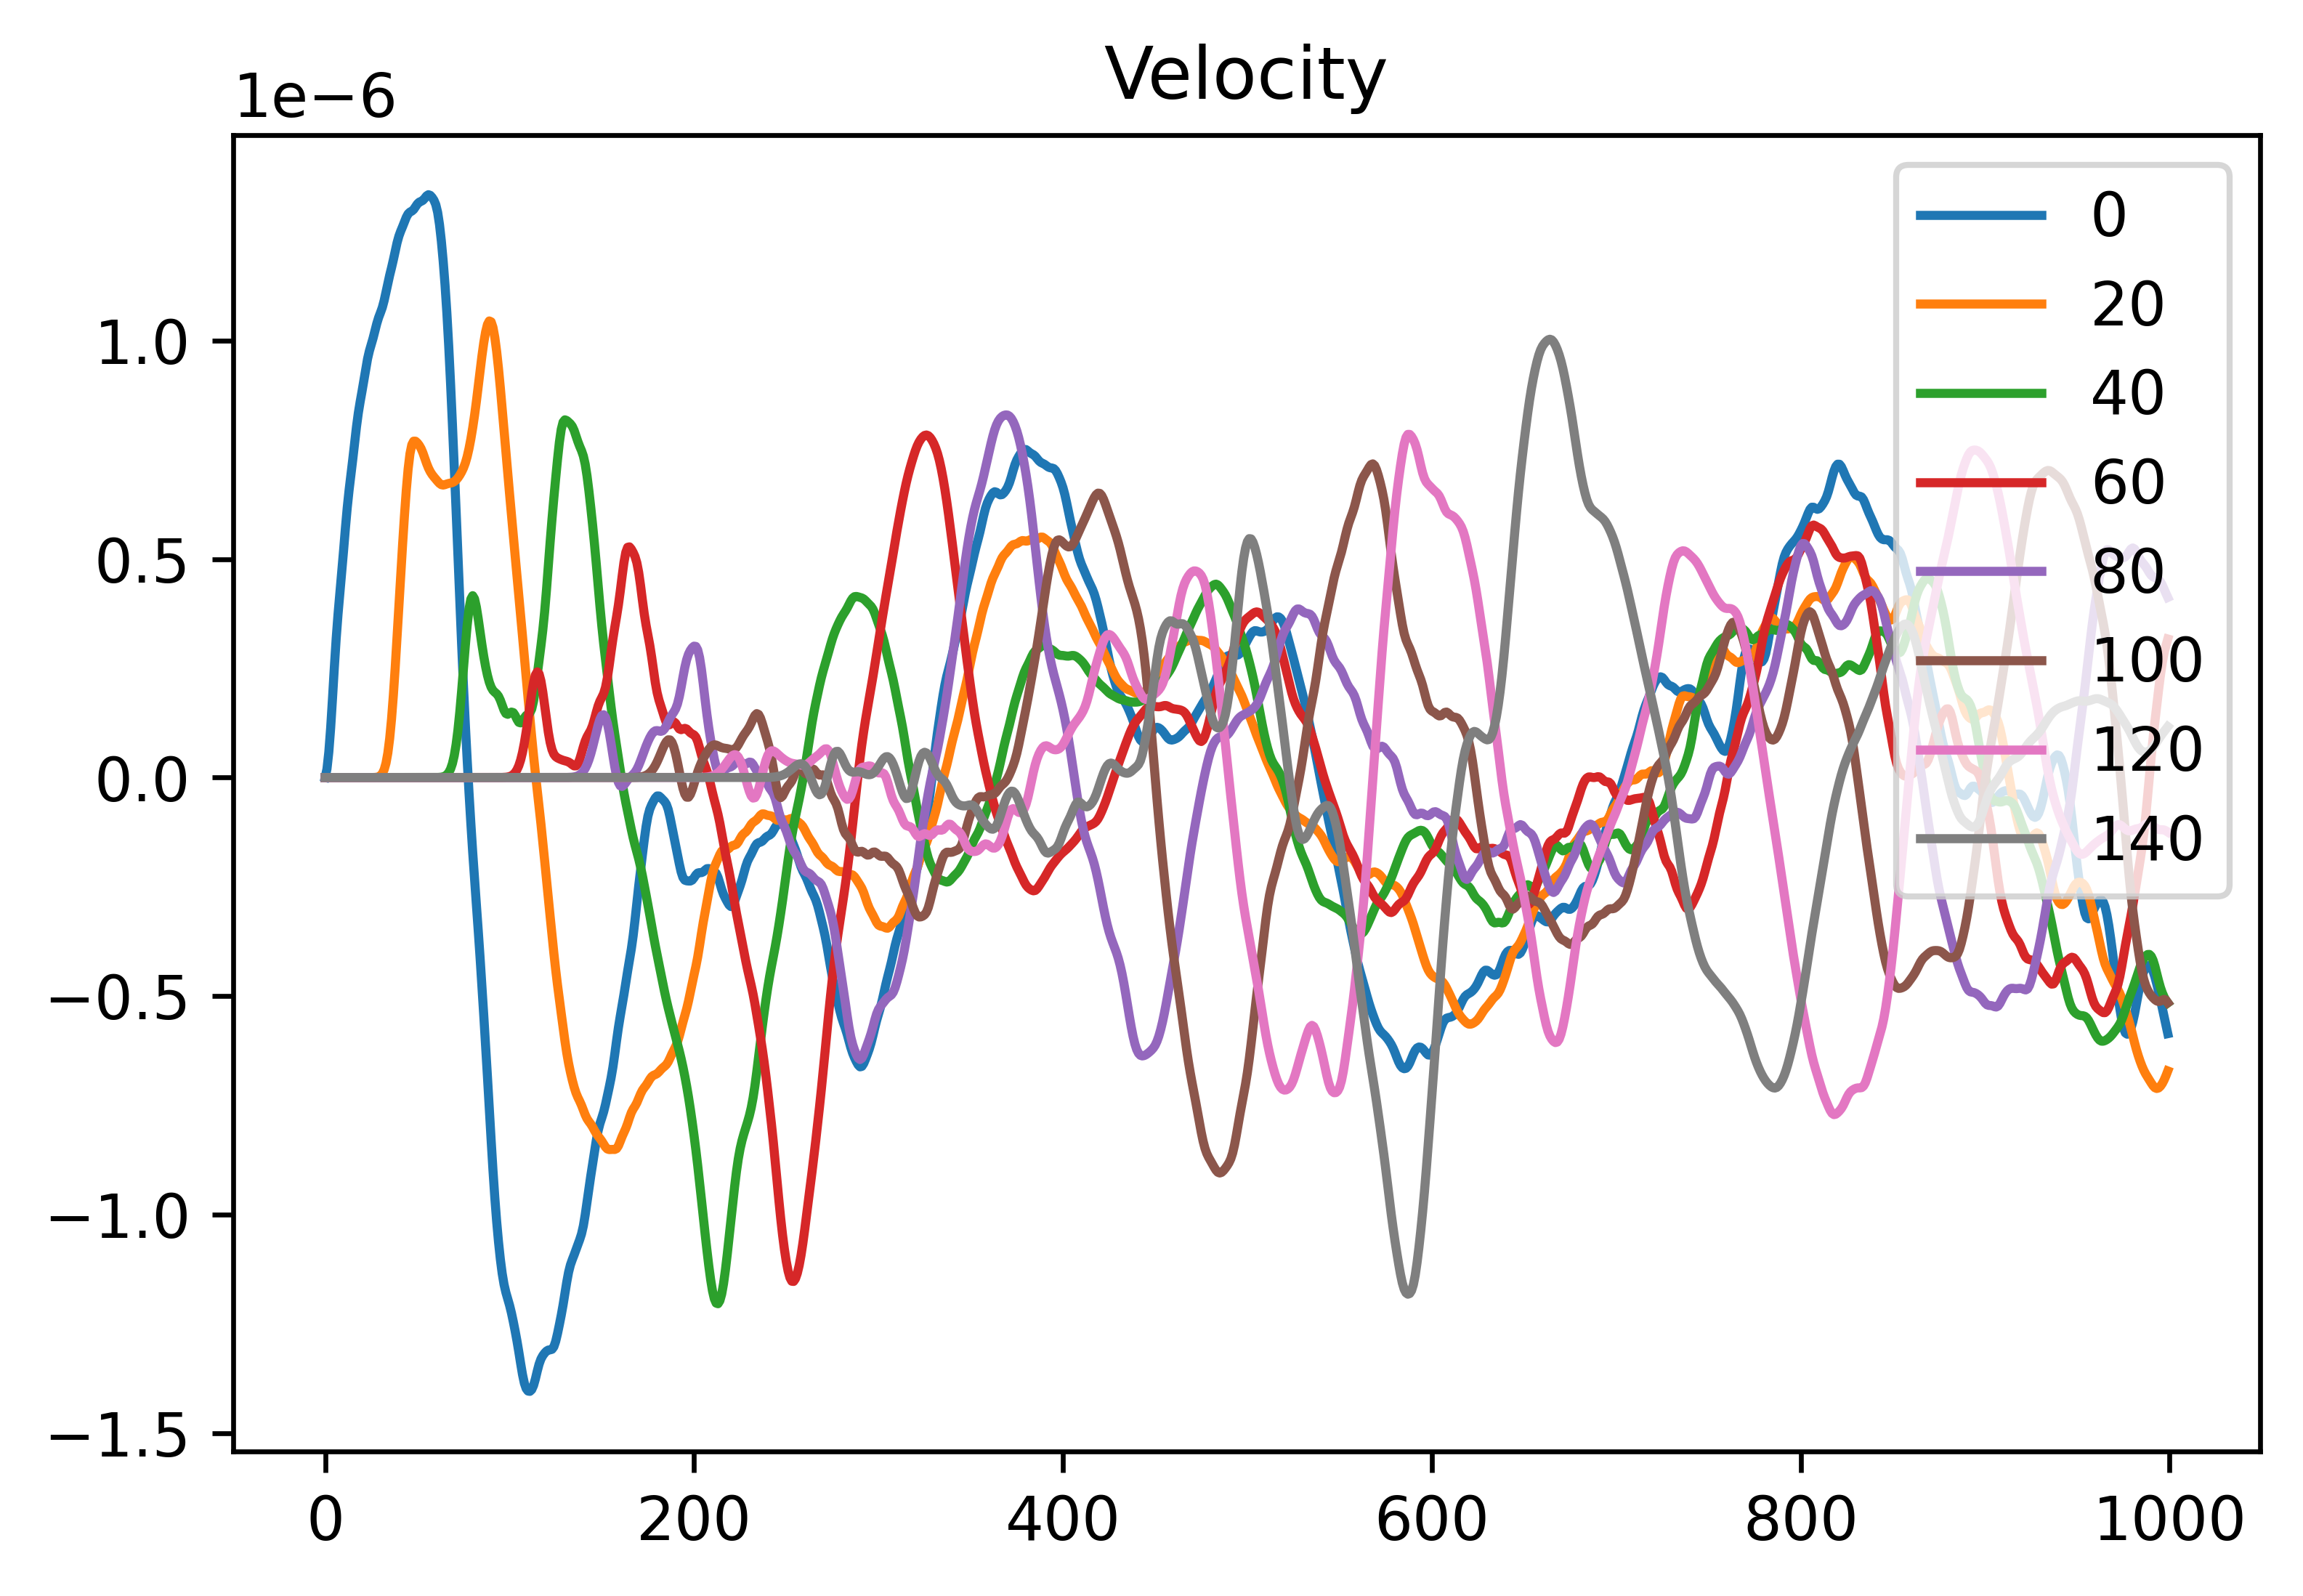

In [30]:
fig = plt.figure(dpi=600, figsize=(6,4))

for i in range(8):
    plt.plot(MidMatrix[i*20,:],label=str(i*20))
plt.title('Velocity')
plt.legend()
plt.show()


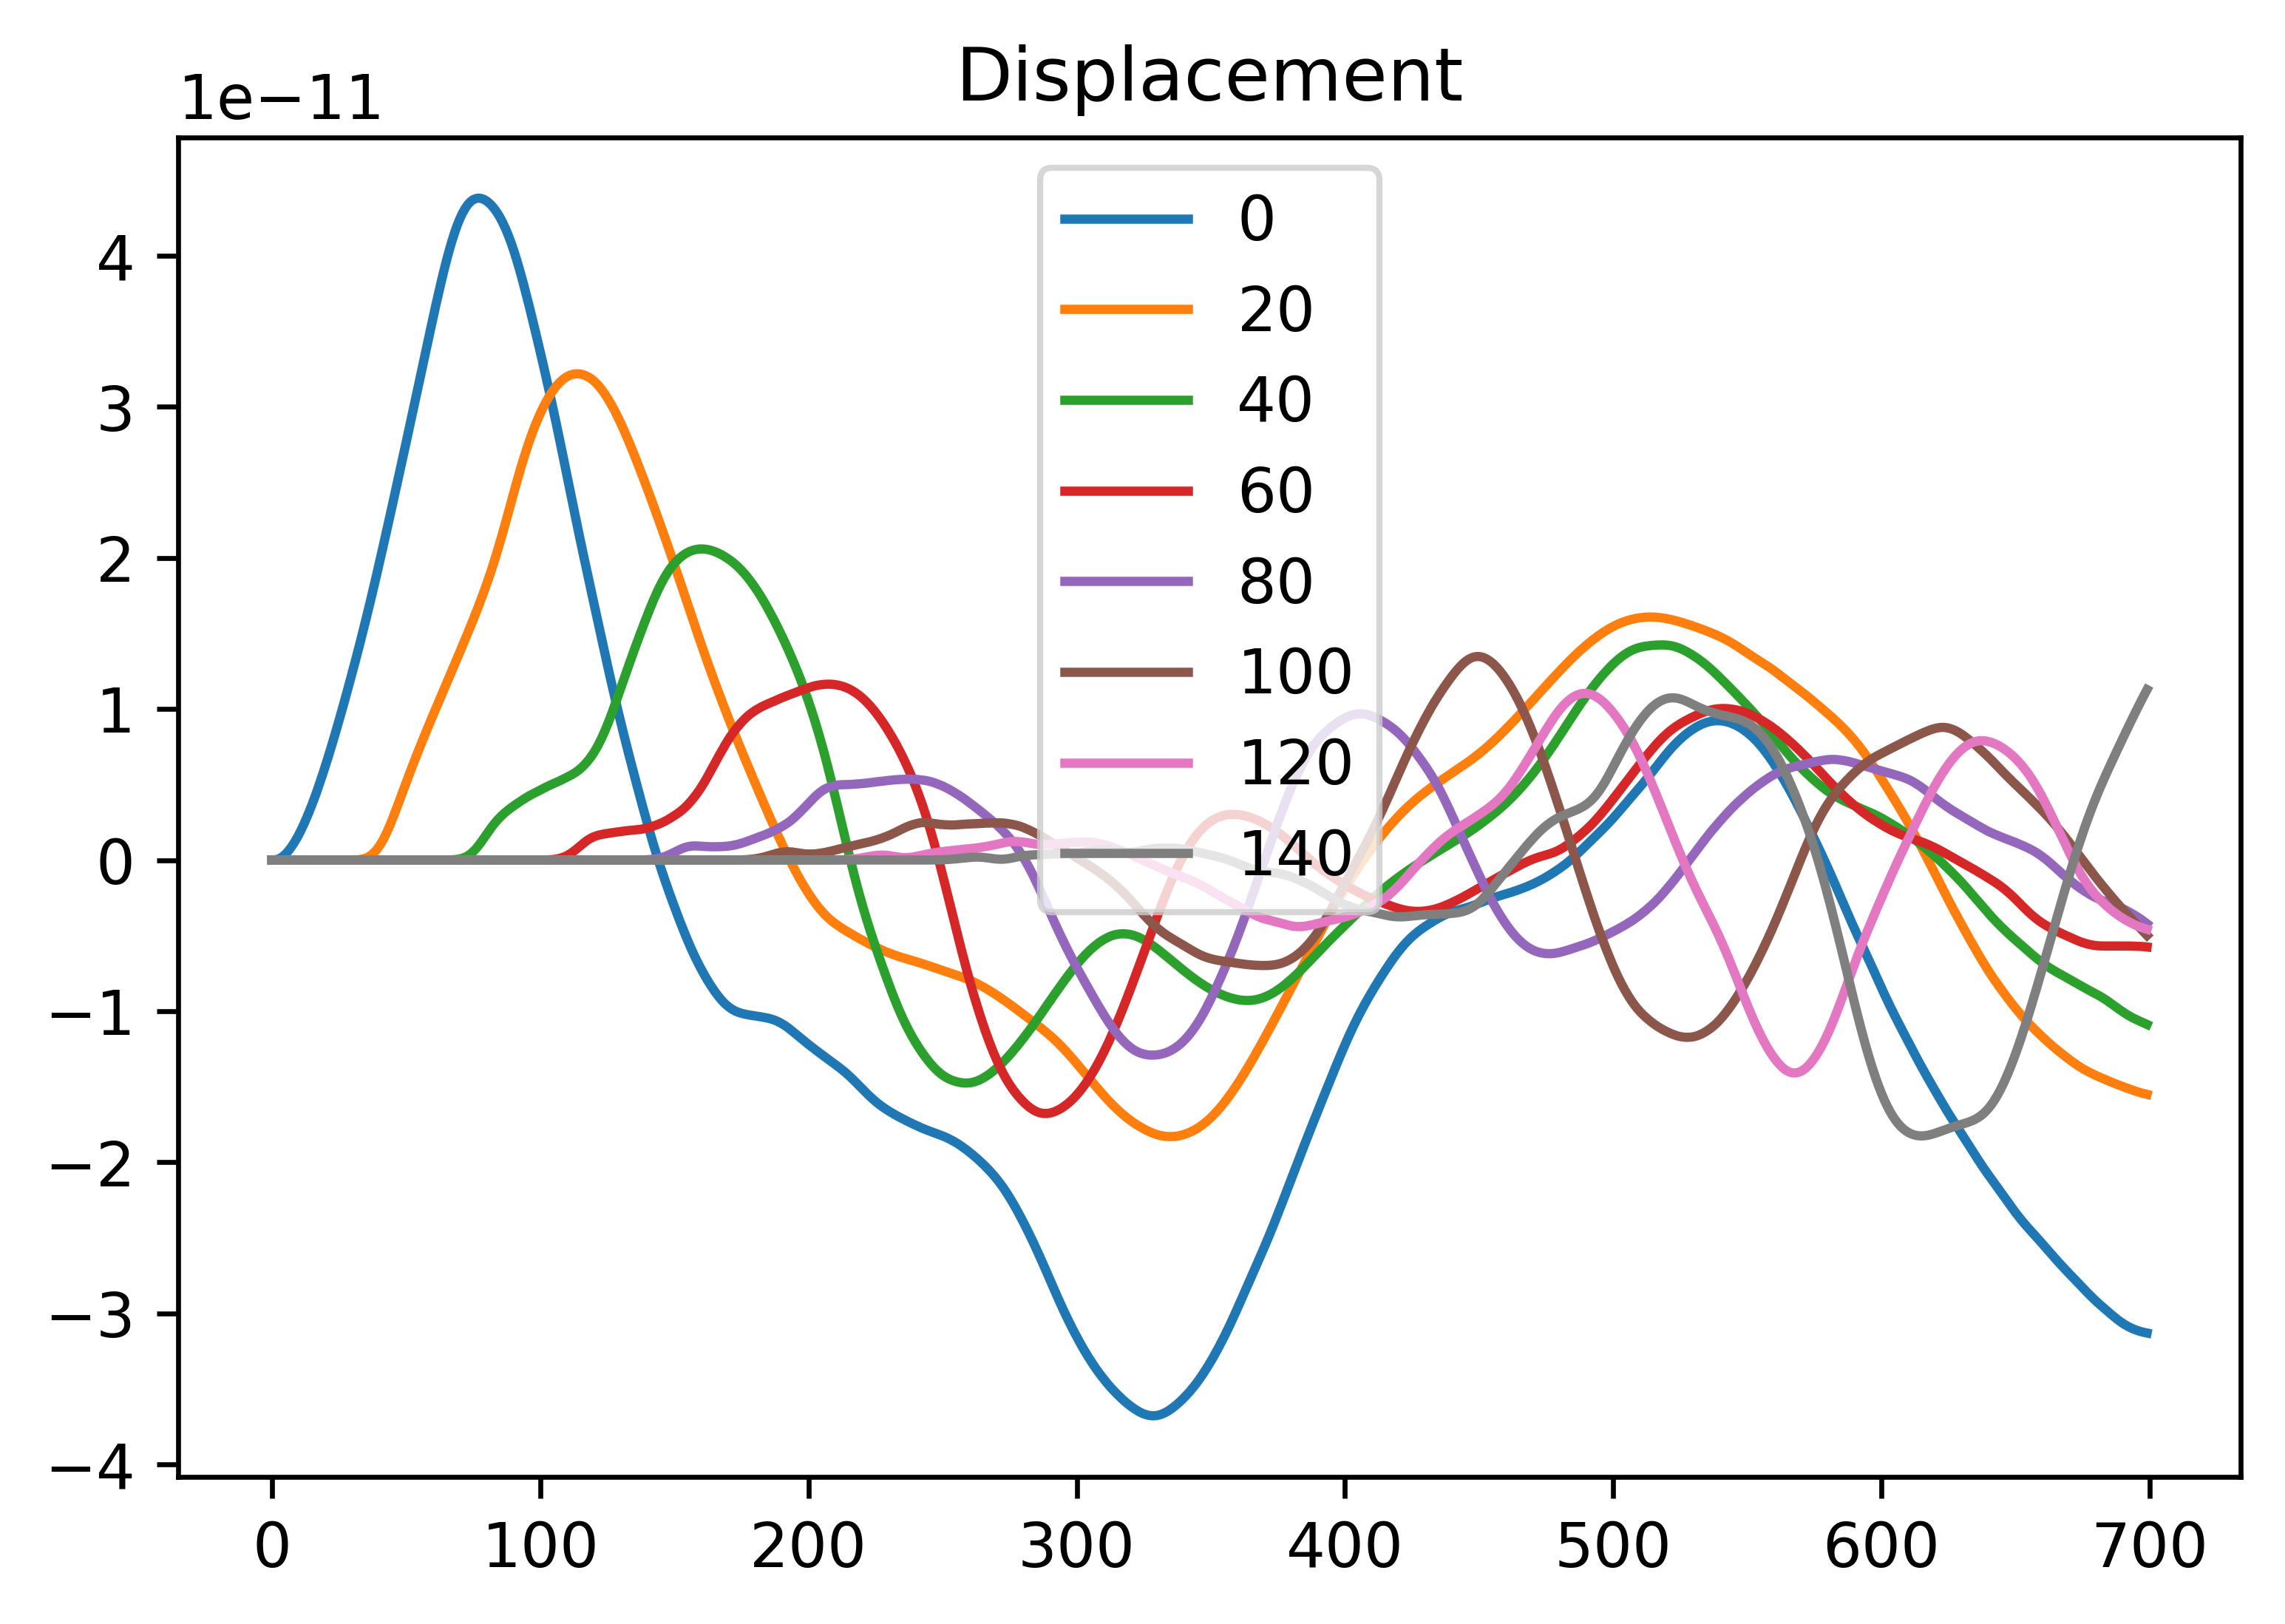

In [31]:
end = 700
fig = plt.figure(dpi=600, figsize=(6,4))

for i in range(8):
    plt.plot(MidDisplace[i*20,:end],label=str(i*20))
plt.legend()
plt.title('Displacement')
plt.show()


In [32]:
np.savetxt(runName+"-MidLineDisplacement.csv",MidDisplace,delimiter=",")
np.savetxt(runName+"-MidLineVelocity.csv",MidMatrix,delimiter=",")